In [2]:
# Importing necessary modules
import gc
import copy
import os
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
from model_data_definitions import *
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import os
import numpy as np

In [29]:
def modelNames():

    models = ["Linear Model",
              "Wide ReLU ANN",
              "Deep ReLU ANN", 
              "One Parameter"
    ]

    for partition_num in [1,2,4,8,10]:
        models.append(f"Spline ANN (z={partition_num})")
        models.append(f"Lookup Table (z={partition_num})")
        models.append(f"ABEL-Spline (z={partition_num})")

    return models

def modelNames():

    models = ["Linear Model",
              "Wide ReLU ANN",
              "Deep ReLU ANN"             
             ]

    for partition_num in [1,2,4,8,10]: 
        models.append(f"Spline ANN (z={partition_num})")
        
    for partition_num in [1,2,4,8,10]: 
        models.append(f"ABEL-Spline (z={partition_num})")
        
    for partition_num in [1,2,4,8,10]: 
        models.append(f"Lookup Table (z={partition_num})")

    return models

model_names = modelNames()

print(model_names)

['Linear Model', 'Wide ReLU ANN', 'Deep ReLU ANN', 'One Parameter', 'Spline ANN (z=1)', 'Spline ANN (z=2)', 'Spline ANN (z=4)', 'Spline ANN (z=8)', 'Spline ANN (z=10)', 'ABEL-Spline (z=1)', 'ABEL-Spline (z=2)', 'ABEL-Spline (z=4)', 'ABEL-Spline (z=8)', 'ABEL-Spline (z=10)', 'Lookup Table (z=1)', 'Lookup Table (z=2)', 'Lookup Table (z=4)', 'Lookup Table (z=8)', 'Lookup Table (z=10)']


# Function to train and evaluate model

def train_evaluate_model(model_tuple, fold_data, epoch_number, dataset_name,num_folds):
    
    
    model, name = model_tuple
    X_train, y_train, X_test, y_test , fold = fold_data
    
    print(f"Evaluating{name} for {fold}")
    
    # Training the model 
    history = model.fit(X_train,
                        y_train,
                        epochs=epoch_number,
                        verbose=1,
                        validation_data=(X_test,y_test))

     # Evaluating the trained model on test data 
    loss = model.evaluate(X_test,y_test)

     # Making predictions on the test data 
    predictions = model.predict(X_test)
    
     # Calculate metrics 
    r_squared_value=r2_score(y_true=y_test,y_pred=predictions)
    test_error=mean_squared_error(y_true=y_test,y_pred=predictions)

    results = {
        'model': name,
        'fold': fold,
        'train_history': history.history['loss'],
        'val_history': history.history['val_loss'],
        'loss': loss,
        'r_squared_value': r_squared_value,
        'test_error': test_error}

    # Save results to numpy file
    if not os.path.exists('aggregate_results'):
        os.makedirs('aggregate_results')

    np.save(f'aggregate_results/{dataset_name}-{name}-epochs-{epoch_number}-fold-{fold}-of-{num_folds}.npy', results)

# Directory where your npy files are stored
directory = 'aggregate_results'

# Initialize dictionary to hold data
data = {}

# Get list of all model names
models = initialize_all_models(1, 1)  # Arguments don't matter here.
model_names = [name for _, name in models]

# Iterate over files in directory
for filename in os.listdir(directory):
    if "-epochs-100-fold-" in filename and "-of-10.npy" in filename:
        #print(filename)
        
        # Split filename into parts
        parts = filename.split('-')
        print(parts)
        #print(parts[-3])

        # Extract dataset name (up to first hyphen)
        dataset_name = parts[0]
        #print(dataset_name)
        
        # Extract model name (from first hyphen to "epochs")
        model_name_parts = parts[1:-6].copy()
        model_name = '-'.join(model_name_parts)
        #print(model_name)

        # Skip file if not one of the expected models
        #if model_name not in model_names:
        #    continue

        # Extract fold number (from "fold" to "of")
        fold_number = parts[-3]
        
        # Load file 
        file_data = np.load(os.path.join(directory, filename), allow_pickle=True).item()

        # Add data to dictionary
        if dataset_name not in data:
            data[dataset_name] = {}
            
        if model_name not in data[dataset_name]:
            data[dataset_name][model_name] = {}

        data[dataset_name][model_name][fold_number] = file_data

# Now you can access the data as follows:
# data[dataset_name][model_name][fold_number]


In [4]:
#np.save('data_dictionary_100_epochs_10_folds.npy', data)
data = np.load('data_dictionary_100_epochs_10_folds.npy', allow_pickle=True).item()

In [6]:
# Function to calculate mean and standard deviation of a metric for each fold for each model, over all datasets
def calculate_mean_std_metric(metric):
    # Initialize dictionary to hold means and standard deviations
    means_stds = {}

    # Iterate over datasets
    for dataset_name in data:
        # Iterate over models
        for model_name in data[dataset_name]:
            # Initialize list to hold metric values for this model
            metric_values = []

            # Iterate over folds
            for fold_number in data[dataset_name][model_name]:
                # Add metric value to list
                metric_values.append(data[dataset_name][model_name][fold_number][metric])

            # Calculate mean and standard deviation and add to dictionary
            mean_metric = np.mean(metric_values)
            std_metric = np.std(metric_values)
            
            if dataset_name not in means_stds:
                means_stds[dataset_name] = {}
                
            if model_name not in means_stds[dataset_name]:
                means_stds[dataset_name][model_name] = {}

            means_stds[dataset_name][model_name]['mean'] = mean_metric
            means_stds[dataset_name][model_name]['std'] = std_metric

    return means_stds

# Calculate mean and standard deviation of r_squared value for each fold for each model, over all datasets
mean_std_r_squared_values = calculate_mean_std_metric('r_squared_value')
#print(mean_std_r_squared_values)

# Calculate mean and standard deviation of test_error value for each fold for each model, over all datasets
mean_std_test_error_values = calculate_mean_std_metric('test_error')
#print(mean_std_test_error_values)

# Calculate mean and standard deviation of loss value for each fold for each model, over all datasets
mean_std_loss_values = calculate_mean_std_metric('loss')
#print(mean_std_loss_values)

In [7]:
mean_std_test_error_values['1027_ESL']['ABEL-Spline (z=4)']

{'mean': 0.1537955905837096, 'std': 0.03651069763983501}

In [8]:
filtered_datasets_metadata, datasets = fetch_return_filtered_pmlb_data_sets()
filtered_datasets_metadata

dataset  n_instances  n_features  \
0                         1027_ESL          488           4   
2                         1029_LEV         1000           4   
3                         1030_ERA         1000           4   
5             1096_FacultySalaries           50           4   
13                    192_vineyard           52           2   
23                     228_elusage           55           2   
25                 230_machine_cpu          209           6   
29         485_analcatdata_vehicle           48           4   
32                      519_vinnie          380           2   
34         523_analcatdata_neavote          100           2   
36                      529_pollen         3848           4   
40          556_analcatdata_apnea2          475           3   
41          557_analcatdata_apnea1          475           3   
48                579_fri_c0_250_5          250           5   
60                594_fri_c2_100_5          100           5   
62                596_fri_c2_250_5          250           5   
63                597_fri_c2_500_5          500           5   
65               599_fri_c2_1000_5         1000           5   
66                601_fri_c1_250_5          250           5   
74               609_fri_c0_1000_5         1000           5   
75                611_fri_c3_100_5          100           5   
76               612_fri_c1_1000_5         1000           5   
77                613_fri_c3_250_5          250           5   
80                617_fri_c3_500_5          500           5   
86                624_fri_c0_100_5          100           5   
89               628_fri_c3_1000_5         1000           5   
90                631_fri_c1_500_5          500           5   
102               649_fri_c0_500_5          500           5   
107               656_fri_c1_100_5          100           5   
111                   663_rabe_266          120           2   
112            665_sleuth_case2002          147           6   
114  678_visualizing_environmental          111           3   
115              687_sleuth_ex1605           62           5   
116         690_visualizing_galaxy          323           4   
118            706_sleuth_case1202           93           6   
119            712_chscase_geyser1          222           2   
155                         banana         5300           2   
270                        titanic         2201           3   

     n_binary_features  n_categorical_features  n_continuous_features  \
0                    0                       0                      4   
2                    0                       0                      4   
3                    0                       0                      4   
5                    0                       0                      4   
13                   0                       0                      2   
23                   0                       0                      2   
25                   0                       0                      6   
29                   0                       0                      4   
32                   0                       0                      2   
34                   0                       0                      2   
36                   0                       0                      4   
40                   0                       0                      3   
41                   0                       0                      3   
48                   0                       0                      5   
60                   0                       0                      5   
62                   0                       0                      5   
63                   0                       0                      5   
65                   0                       0                      5   
66                   0                       0                      5   
74                   0                       0                      5   
75                   0              

In [9]:
filtered_datasets_metadata.columns

Index(['dataset', 'n_instances', 'n_features', 'n_binary_features',
       'n_categorical_features', 'n_continuous_features', 'endpoint_type',
       'n_classes', 'imbalance', 'task'],
      dtype='object')

In [10]:
# Function to save means and standard deviations to a text file in LaTeX table format
def save_to_file(means_stds, filename):
    # Create dictionaries mapping dataset names to number of instances and number of features
    instances_dict = filtered_datasets_metadata.set_index('dataset')['n_instances'].to_dict()
    features_dict = filtered_datasets_metadata.set_index('dataset')['n_features'].to_dict()

    # Get all unique feature counts
    unique_features_counts = sorted(list(set(features_dict.values())))

    # Open file
    with open(filename, 'w') as f:

        # Iterate over feature counts
        for feature_count in unique_features_counts:
            # Get datasets with current feature count and sort them based on number of instances
            datasets_with_feature_count = [dataset for dataset, features in features_dict.items() if features == feature_count]
            sorted_datasets = sorted(datasets_with_feature_count, key=lambda x: instances_dict[x])

            if not sorted_datasets:
                continue

            # Write table header
            header = " & ".join(["\\texttt{" + dataset.replace("_", "\\_") + "}" for dataset in sorted_datasets])
            f.write("\\begin{tabular}{|l|" + "c|"*len(sorted_datasets) + "}\n")
            f.write("\\hline\n")
            f.write("Model & " + header + " \\\\\n")
            f.write("\\hline\n")

            # Iterate over models
            for model_name in model_names:
                row_data = []
                for dataset_name in sorted_datasets:
                    if model_name in means_stds[dataset_name]:
                        # Write row data
                        mean = means_stds[dataset_name][model_name]['mean']
                        std = means_stds[dataset_name][model_name]['std']
                        row_data.append(f"{mean:.3f} $\\pm$ {std:.3f}")
                    else:
                        row_data.append("-")
                f.write(f"{model_name} & " + " & ".join(row_data) + " \\\\\n")

            # Write table footer
            f.write("\\hline\n")
            f.write("\\end{tabular}\n")
            f.write("\n")

# Save mean and standard deviation of r_squared value to file
save_to_file(mean_std_r_squared_values, 'r_squared_values.txt')

# Save mean and standard deviation of test_error value to file
save_to_file(mean_std_test_error_values, 'test_error_values.txt')

# Save mean and standard deviation of loss value to file
save_to_file(mean_std_loss_values, 'loss_values.txt')

In [14]:
# attempt rotate
# Function to save means and standard deviations to a text file in LaTeX table format
def save_to_file(means_stds, filename):
    # Create dictionaries mapping dataset names to number of instances and number of features
    instances_dict = filtered_datasets_metadata.set_index('dataset')['n_instances'].to_dict()
    features_dict = filtered_datasets_metadata.set_index('dataset')['n_features'].to_dict()

    # Get all unique feature counts
    unique_features_counts = sorted(list(set(features_dict.values())))

    # Open file
    with open(filename, 'w') as f:

        # Iterate over feature counts
        for feature_count in unique_features_counts:
            # Get datasets with current feature count and sort them based on number of instances
            datasets_with_feature_count = [dataset for dataset, features in features_dict.items() if features == feature_count]
            sorted_datasets = sorted(datasets_with_feature_count, key=lambda x: instances_dict[x])

            if not sorted_datasets:
                continue

            # Write table header with rotated text            
            header = " & ".join(["\\rotatebox{270}{\\texttt{" + dataset.replace("_", "\\_") + "}}" for dataset in sorted_datasets])
            
            f.write("\\begin{tabular}{|l|" + "c|"*len(sorted_datasets) + "}\n")
            f.write("\\hline\n")
            f.write("Model & " + header + " \\\\\n")
            f.write("\\hline\n")

            # Iterate over models
            for model_name in model_names:
                row_data = []
                for dataset_name in sorted_datasets:
                    if model_name in means_stds[dataset_name]:
                        # Write row data
                        mean = means_stds[dataset_name][model_name]['mean']
                        std = means_stds[dataset_name][model_name]['std']
                        row_data.append(f"{mean:.3f} $\\pm$ {std:.3f}")
                    else:
                        row_data.append("-")
                f.write(f"{model_name} & " + " & ".join(row_data) + " \\\\\n")

            # Write table footer
            f.write("\\hline\n")
            f.write("\\end{tabular}\n")
            f.write("\n")

# Save mean and standard deviation of r_squared value to file
save_to_file(mean_std_r_squared_values, 'r_squared_values.txt')

# Save mean and standard deviation of test_error value to file
save_to_file(mean_std_test_error_values, 'test_error_values.txt')

# Save mean and standard deviation of loss value to file
save_to_file(mean_std_loss_values, 'loss_values.txt')

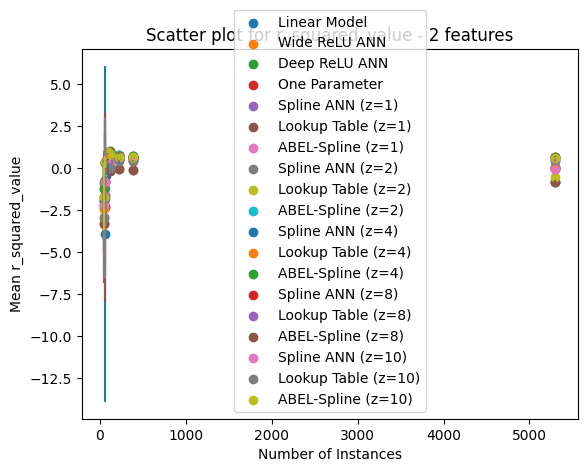

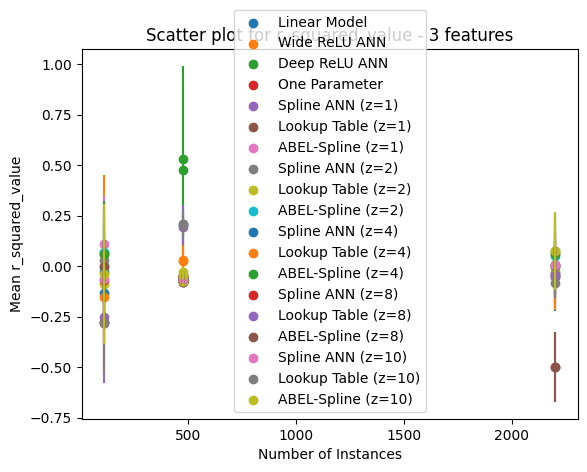

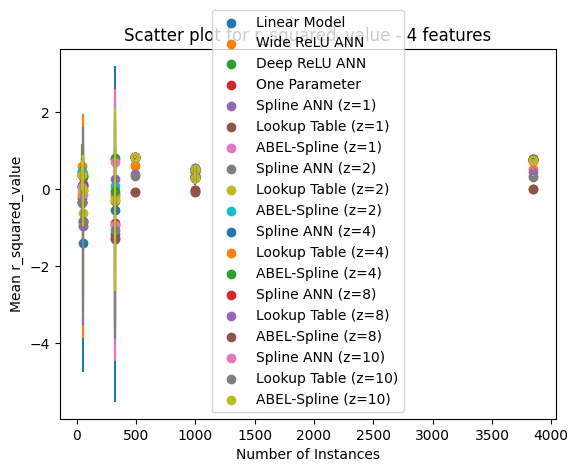

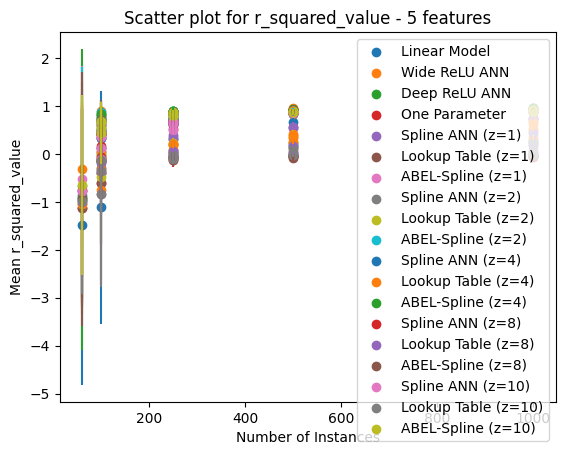

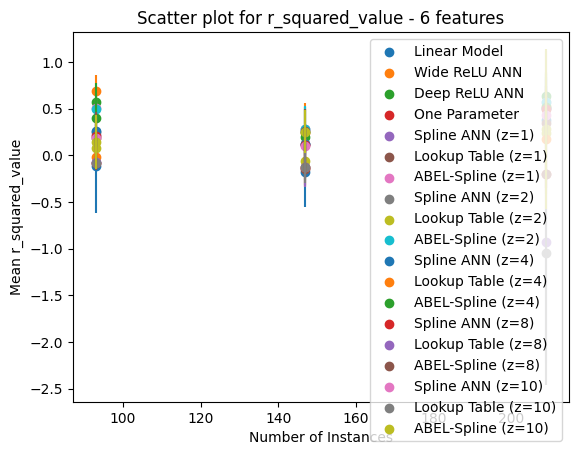

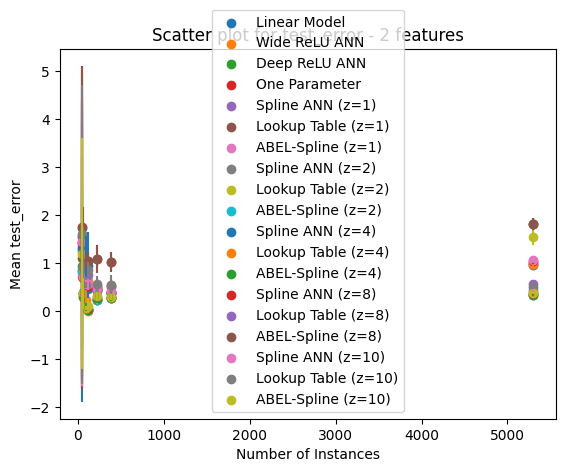

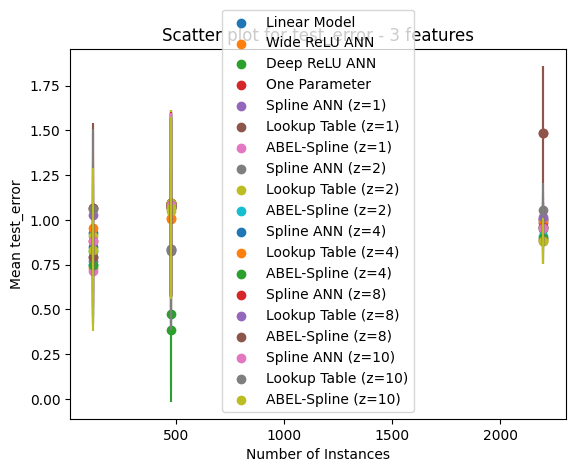

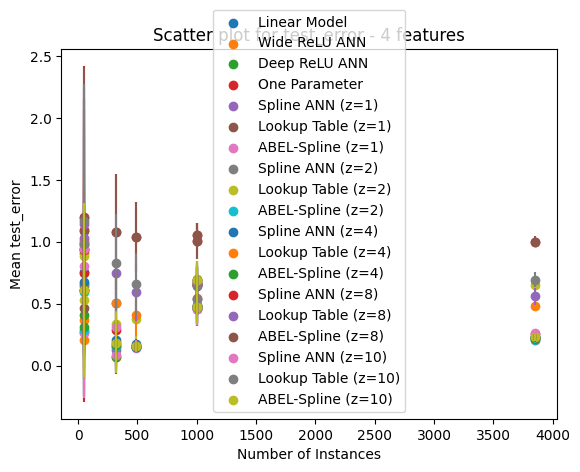

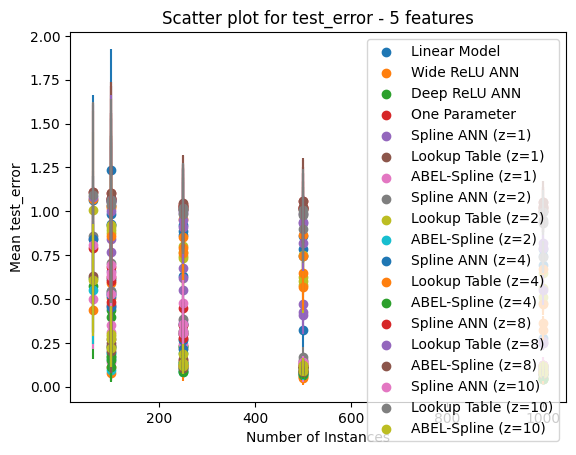

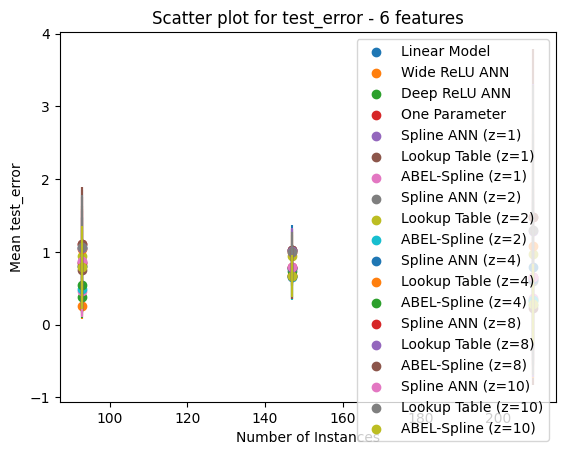

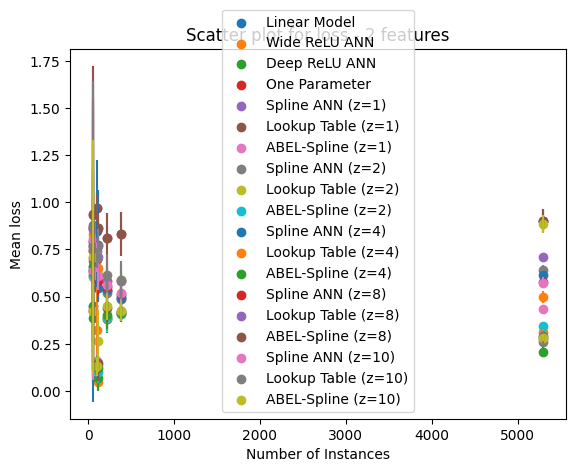

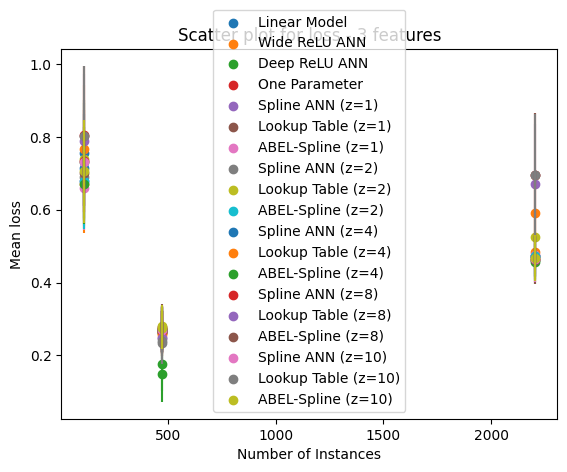

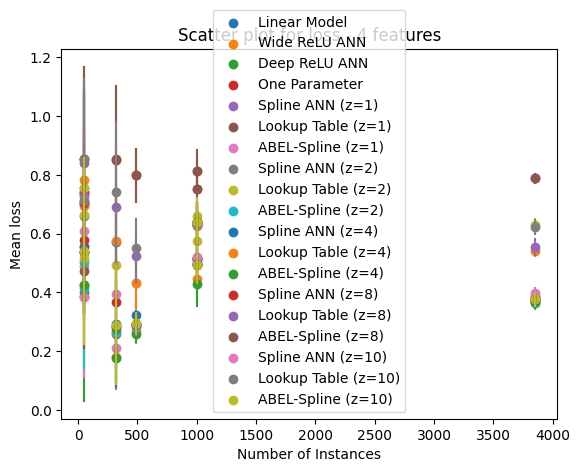

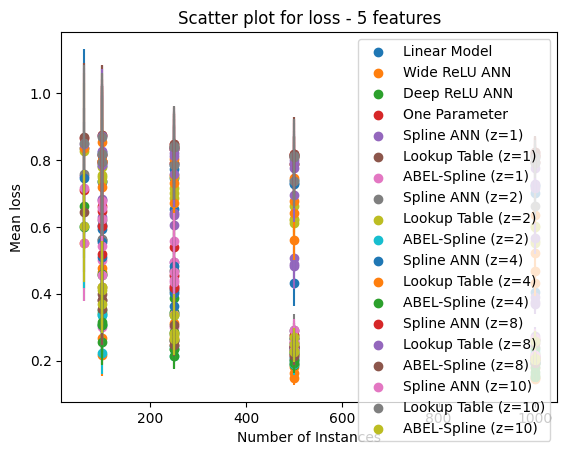

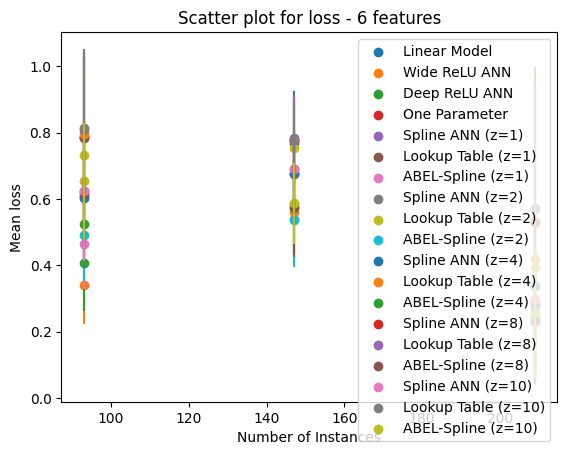

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Function to create scatter plots for mean r_squared value and other metrics
def create_scatter_plots(means_stds, metric):
    # Create dictionaries mapping dataset names to number of instances and number of features
    instances_dict = filtered_datasets_metadata.set_index('dataset')['n_instances'].to_dict()
    features_dict = filtered_datasets_metadata.set_index('dataset')['n_features'].to_dict()

    # Get all unique feature counts
    unique_features_counts = sorted(list(set(features_dict.values())))

    # Iterate over feature counts
    for feature_count in unique_features_counts:
        # Get datasets with current feature count and sort them based on number of instances
        datasets_with_feature_count = [dataset for dataset, features in features_dict.items() if features == feature_count]
        sorted_datasets = sorted(datasets_with_feature_count, key=lambda x: instances_dict[x])

        if not sorted_datasets:
            continue

        # Create figure and axes
        fig, ax = plt.subplots()

        # Iterate over models
        for i, model_name in enumerate(model_names):
            x_values = []
            y_values = []
            std_errors = []

            # Iterate over datasets
            for dataset_name in sorted_datasets:
                if model_name in means_stds[dataset_name]:
                    mean_metric = means_stds[dataset_name][model_name]['mean']
                    std_metric = means_stds[dataset_name][model_name]['std']
                    x_values.append(instances_dict[dataset_name])
                    y_values.append(mean_metric)
                    std_errors.append(std_metric)

            # Plot scatter with error bars
            ax.scatter(x_values, y_values, label=model_name, c=f'C{i}')
            ax.errorbar(x_values, y_values, yerr=std_errors, fmt='none', ecolor=f'C{i}')

        # Set plot title and labels
        ax.set_title(f"Scatter plot for {metric} - {feature_count} features")
        ax.set_xlabel("Number of Instances")
        ax.set_ylabel(f"Mean {metric}")

        # Add legend and show plot
        ax.legend()
        plt.show()

# Create scatter plots for mean r_squared value
create_scatter_plots(mean_std_r_squared_values, 'r_squared_value')

# Create scatter plots for test_error value
create_scatter_plots(mean_std_test_error_values, 'test_error')

# Create scatter plots for loss value
create_scatter_plots(mean_std_loss_values, 'loss')

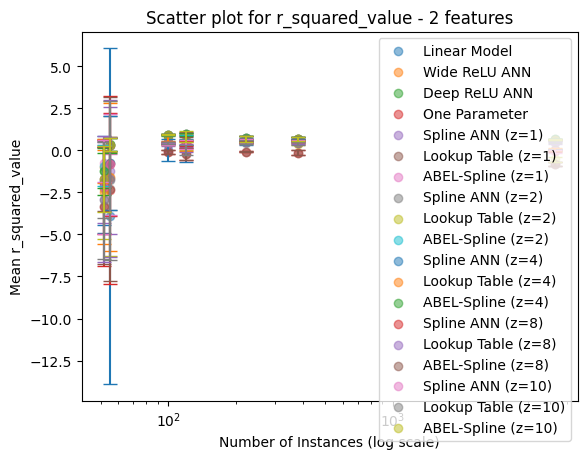

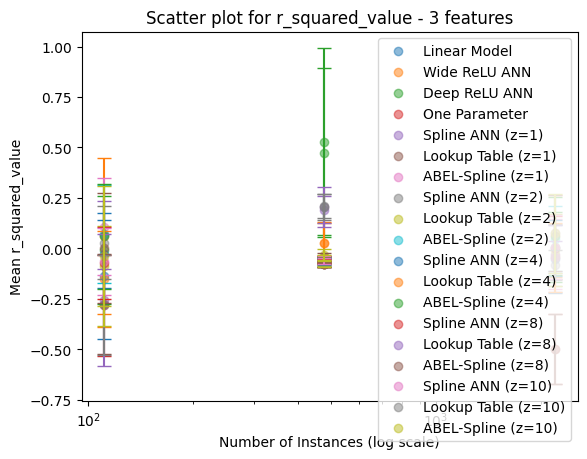

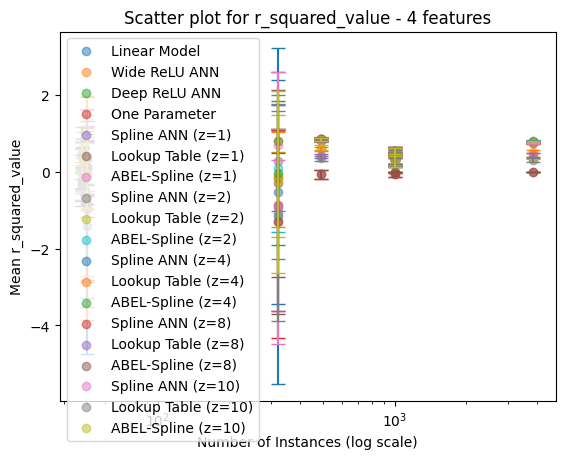

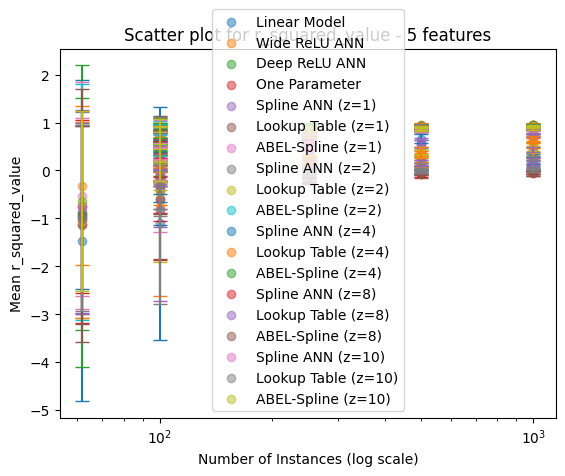

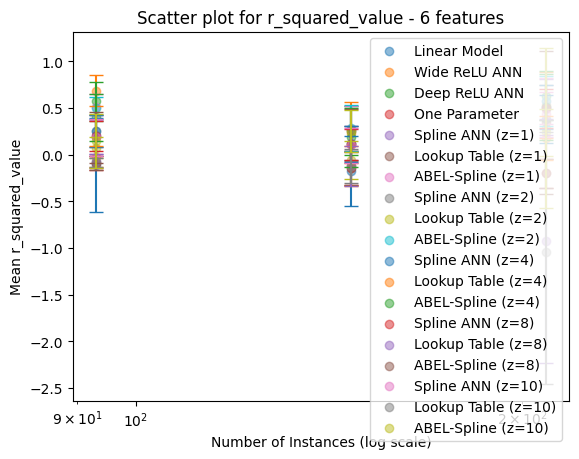

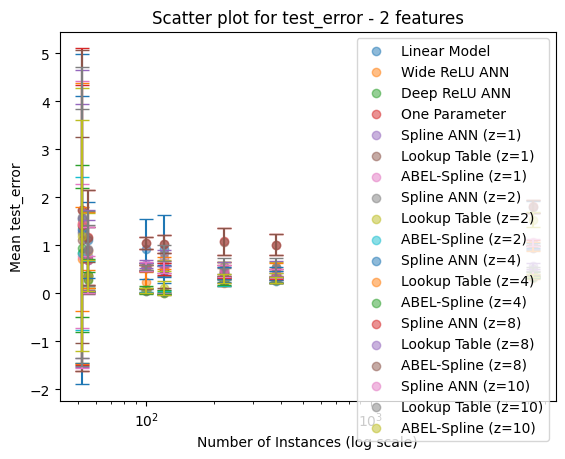

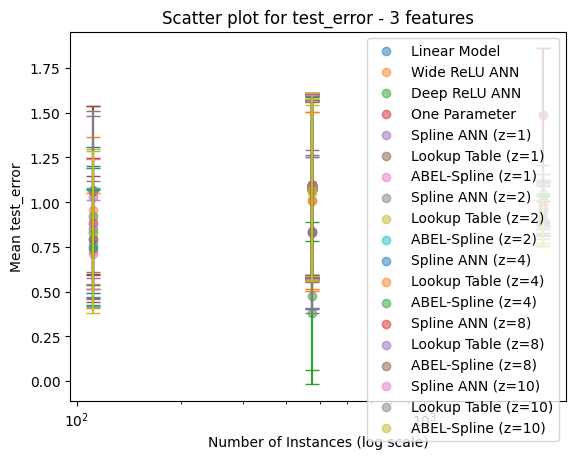

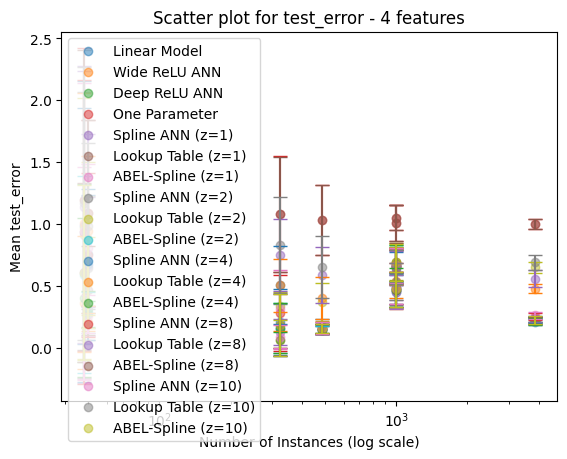

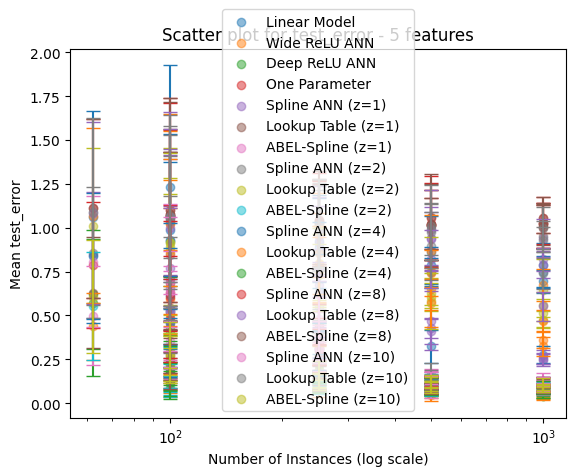

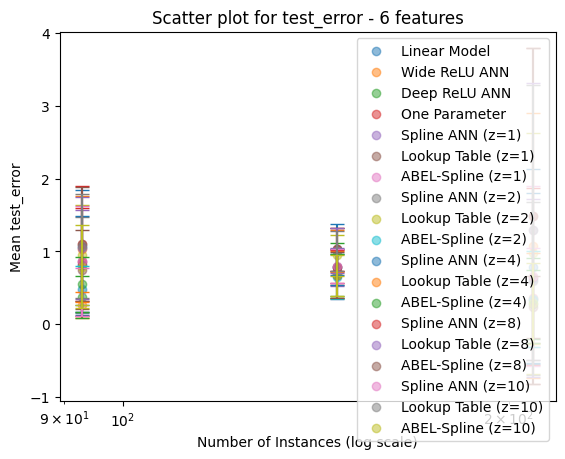

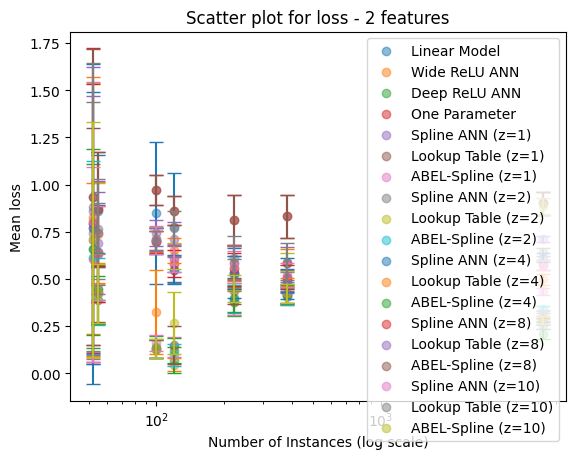

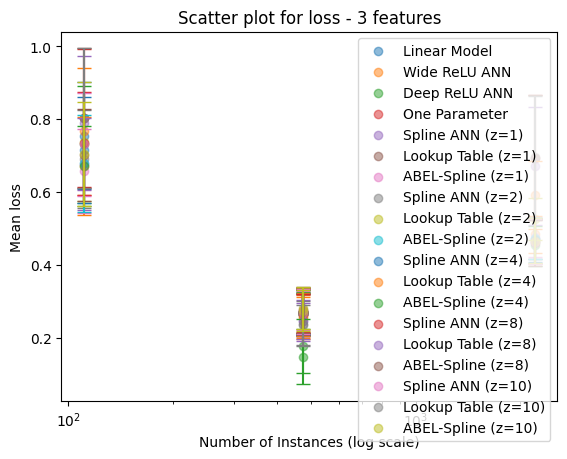

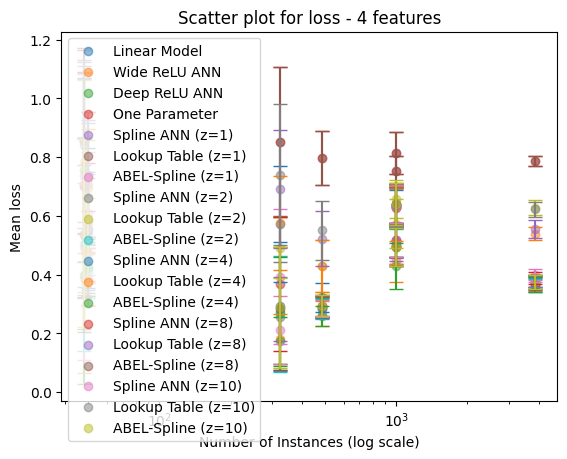

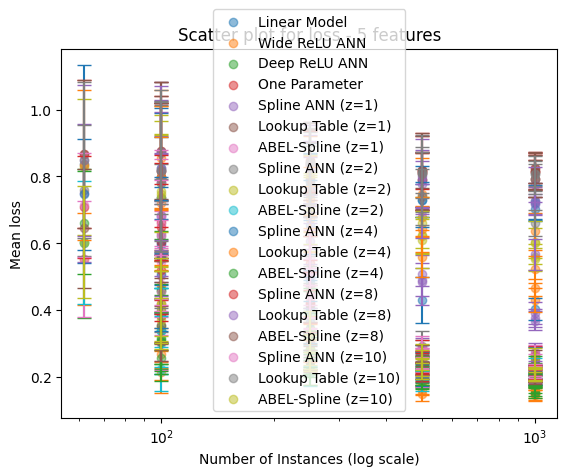

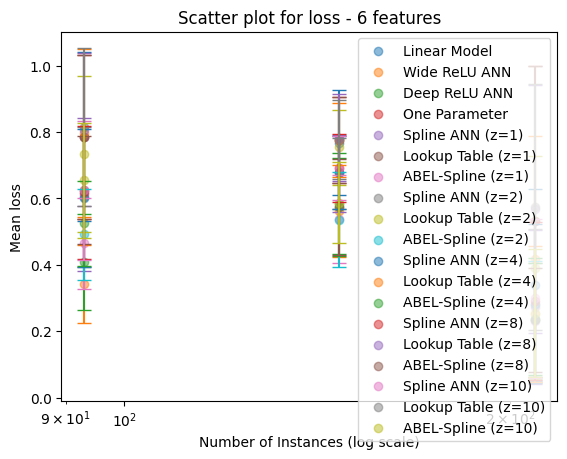

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Function to create scatter plots for mean r_squared value and other metrics
def create_scatter_plots(means_stds, metric):
    # Create dictionaries mapping dataset names to number of instances and number of features
    instances_dict = filtered_datasets_metadata.set_index('dataset')['n_instances'].to_dict()
    features_dict = filtered_datasets_metadata.set_index('dataset')['n_features'].to_dict()

    # Get all unique feature counts
    unique_features_counts = sorted(list(set(features_dict.values())))

    # Iterate over feature counts
    for feature_count in unique_features_counts:
        # Get datasets with current feature count and sort them based on number of instances
        datasets_with_feature_count = [dataset for dataset, features in features_dict.items() if features == feature_count]
        sorted_datasets = sorted(datasets_with_feature_count, key=lambda x: instances_dict[x])

        if not sorted_datasets:
            continue

        # Create figure and axes
        fig, ax = plt.subplots()

        # Set x-axis to be on a logarithmic scale
        ax.set_xscale('log')

        # Iterate over models
        for i, model_name in enumerate(model_names):
            x_values = []
            y_values = []
            std_errors = []

            # Iterate over datasets
            for dataset_name in sorted_datasets:
                if model_name in means_stds[dataset_name]:
                    mean_metric = means_stds[dataset_name][model_name]['mean']
                    std_metric = means_stds[dataset_name][model_name]['std']
                    x_values.append(instances_dict[dataset_name])
                    y_values.append(mean_metric)
                    std_errors.append(std_metric)

            # Plot scatter with error bars
            ax.scatter(x_values, y_values, label=model_name, c=f'C{i}', alpha=0.5)  # Adjust alpha value to make the scatter plot more see-through
            ax.errorbar(x_values, y_values, yerr=std_errors, fmt='none', ecolor=f'C{i}', capsize=5)  # Set 'capsize' to add horizontal lines to the ends of the error bars

        # Set plot title and labels
        ax.set_title(f"Scatter plot for {metric} - {feature_count} features")
        ax.set_xlabel("Number of Instances (log scale)")
        ax.set_ylabel(f"Mean {metric}")

        # Add legend and show plot
        ax.legend()
        plt.show()

# Create scatter plots for mean r_squared value
create_scatter_plots(mean_std_r_squared_values, 'r_squared_value')

# Create scatter plots for test_error value
create_scatter_plots(mean_std_test_error_values, 'test_error')

# Create scatter plots for loss value
create_scatter_plots(mean_std_loss_values, 'loss')

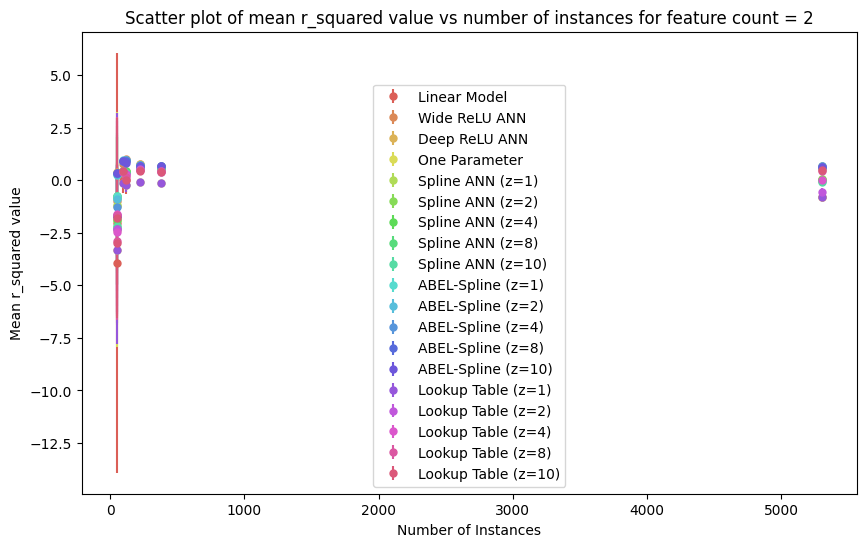

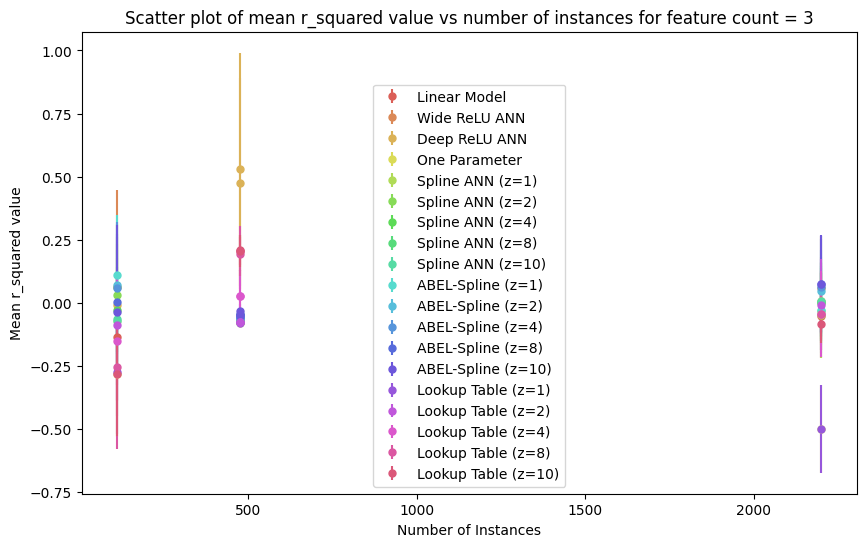

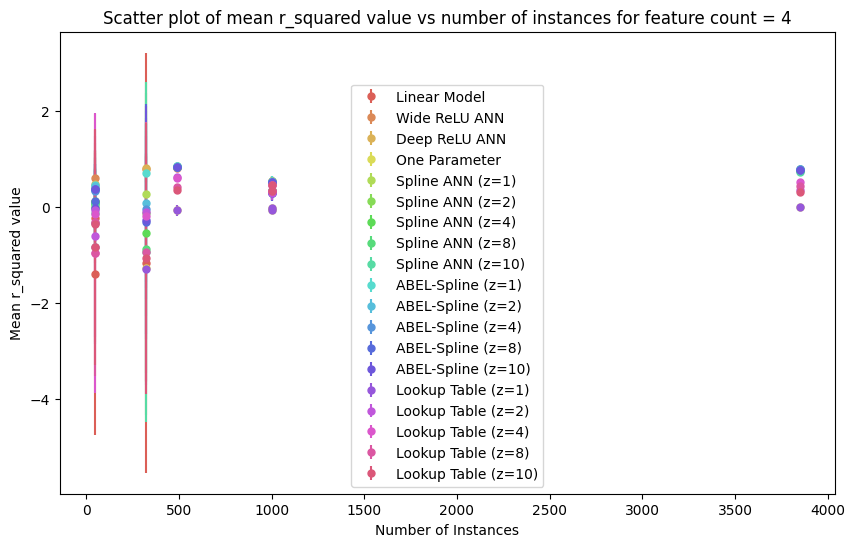

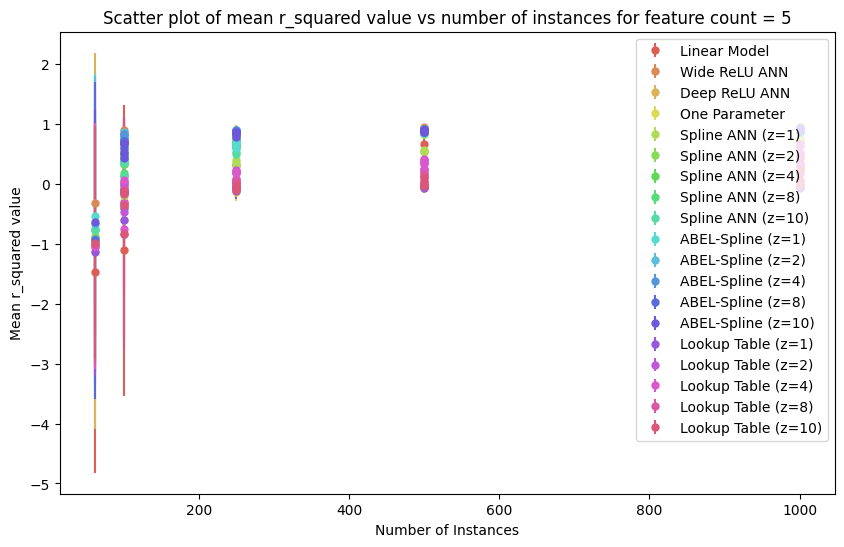

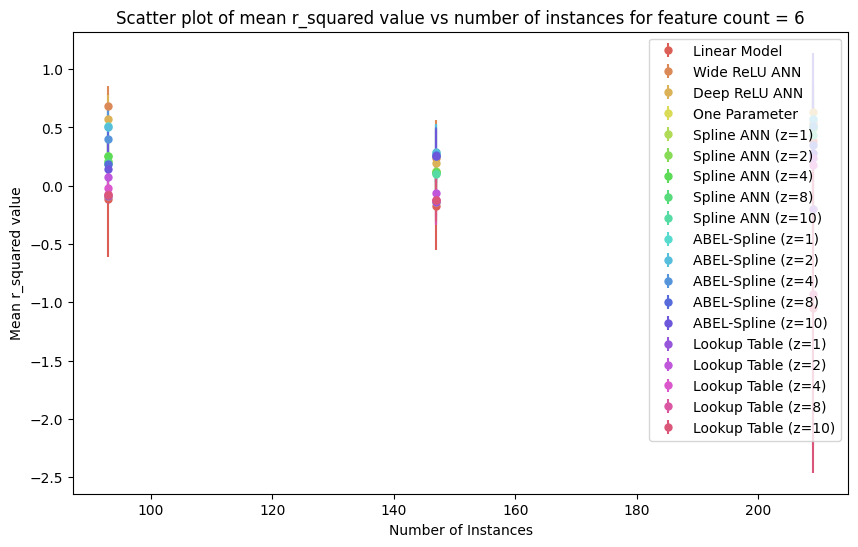

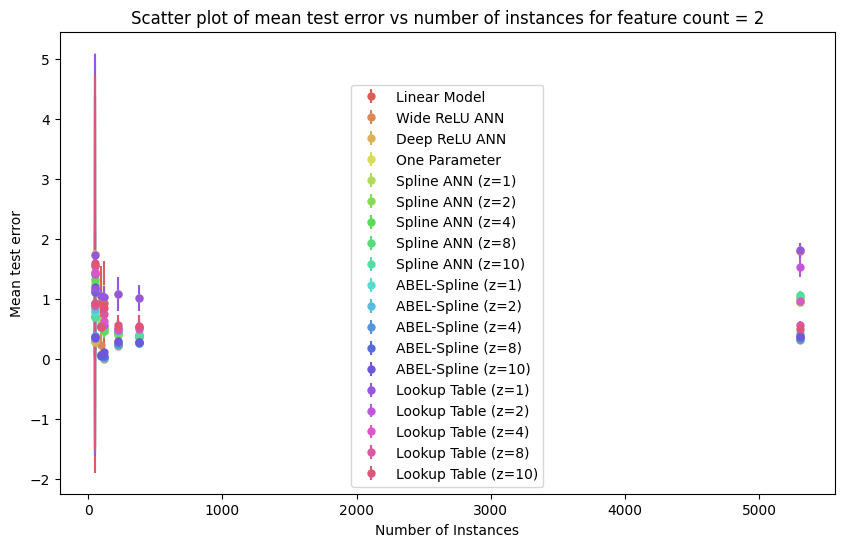

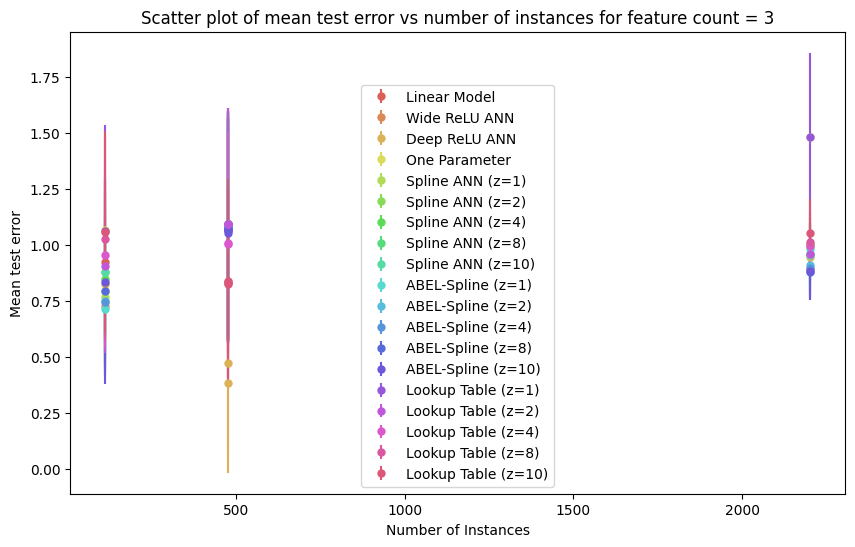

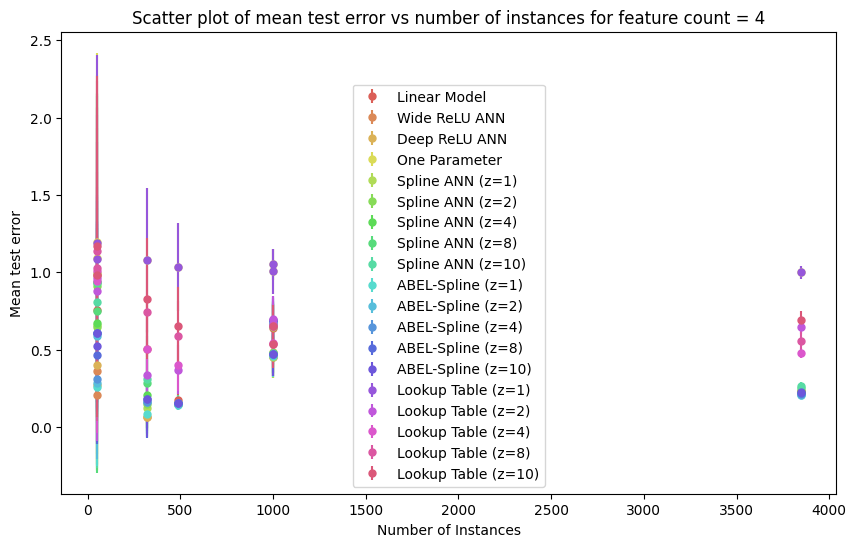

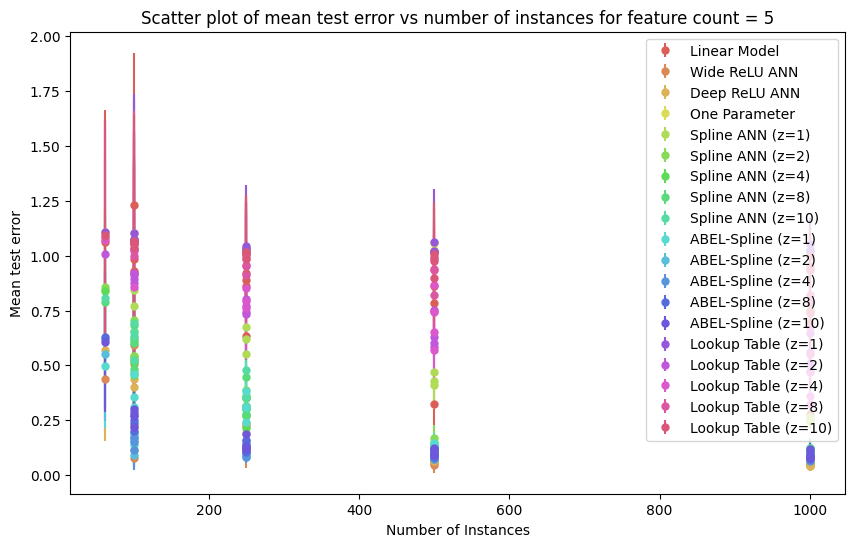

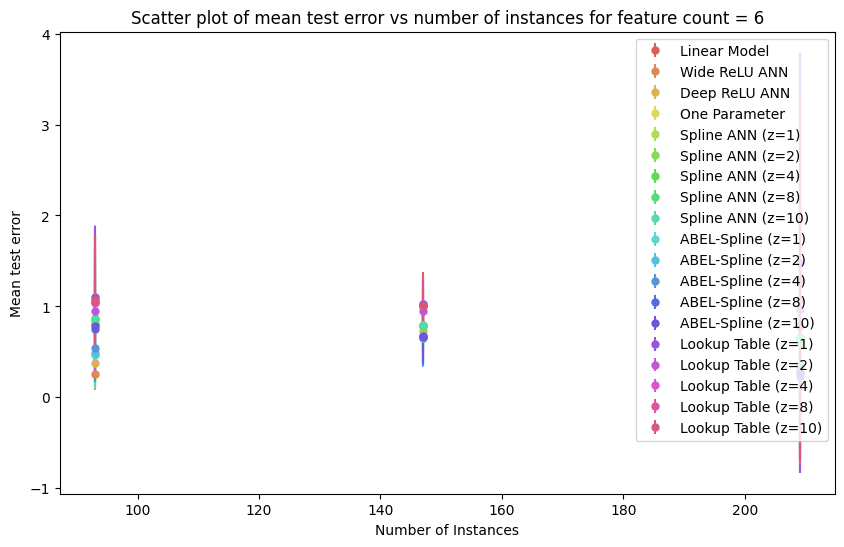

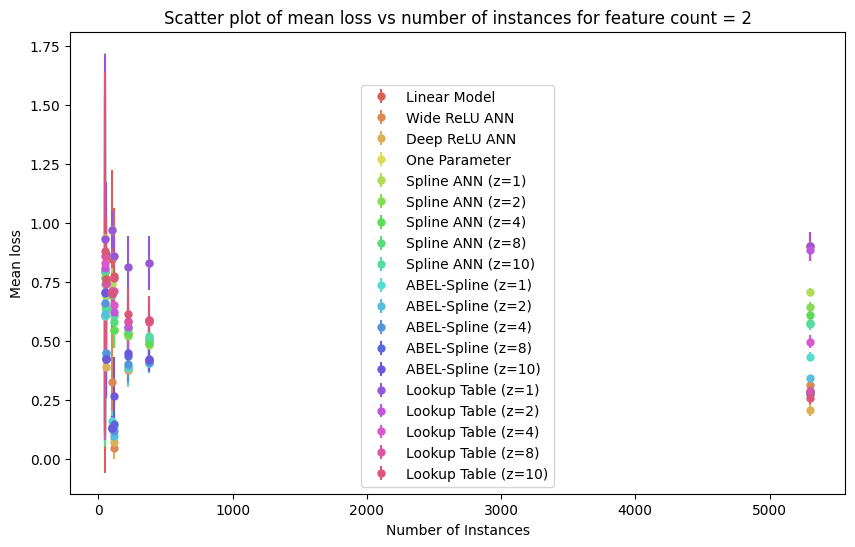

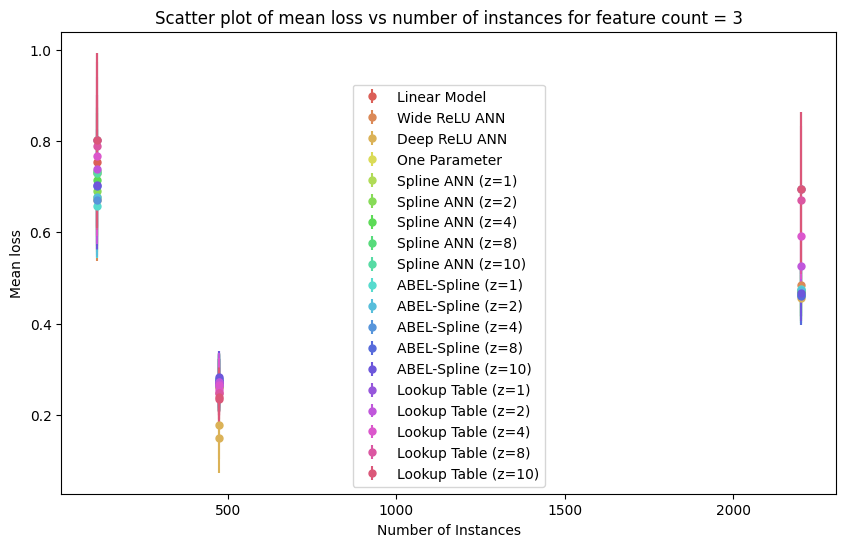

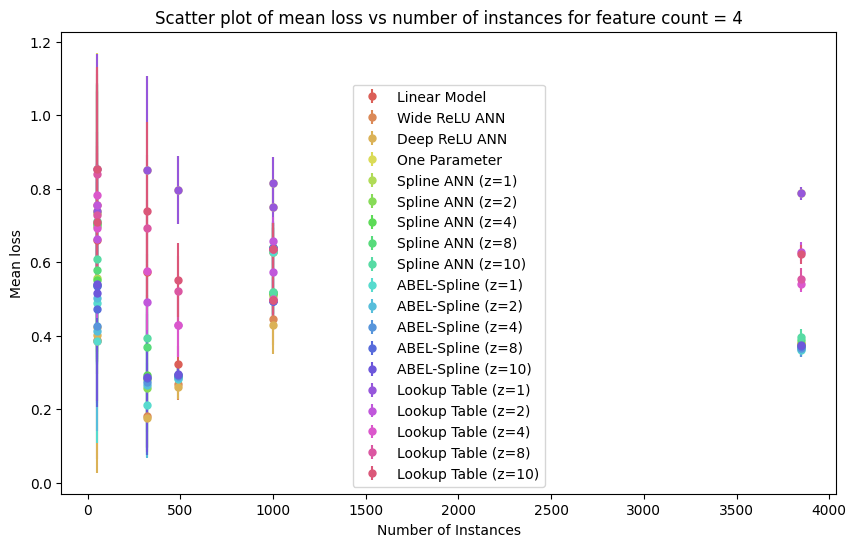

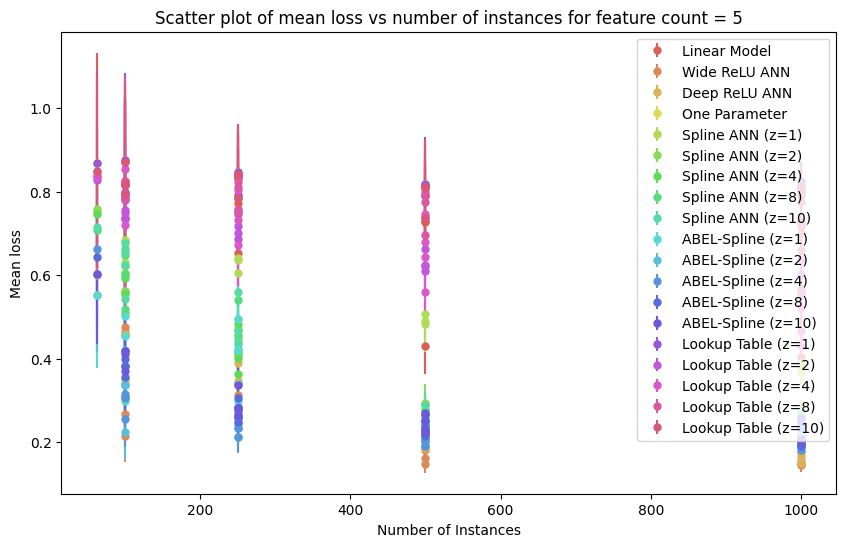

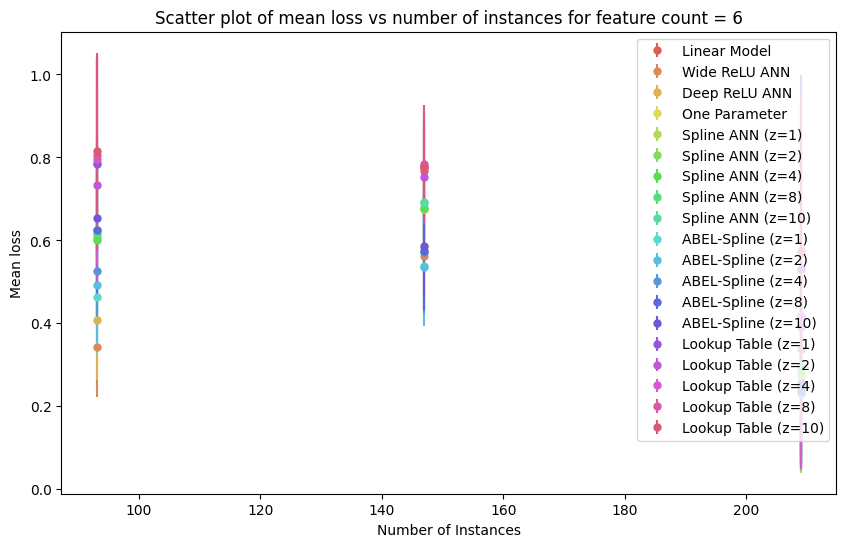

In [19]:
import matplotlib.pyplot as plt 
import seaborn as sns

# Function to create scatter plots of mean metric vs number of instances, with standard deviation error bars
def scatter_plot_metric_vs_instances(means_stds, metric):
    # Create dictionaries mapping dataset names to number of instances and number of features
    instances_dict = filtered_datasets_metadata.set_index('dataset')['n_instances'].to_dict()
    features_dict = filtered_datasets_metadata.set_index('dataset')['n_features'].to_dict()

    # Get all unique feature counts
    unique_features_counts = sorted(list(set(features_dict.values())))

    # Create color palette 
    colors = sns.color_palette("hls", len(model_names))

    # Iterate over feature counts
    for feature_count in unique_features_counts:
        # Get datasets with current feature count and sort them based on number of instances
        datasets_with_feature_count = [dataset for dataset, features in features_dict.items() if features == feature_count]
        sorted_datasets = sorted(datasets_with_feature_count, key=lambda x: instances_dict[x])

        if not sorted_datasets:
            continue

        plt.figure(figsize=(10, 6))
        
        # Iterate over models
        for i, model_name in enumerate(model_names):
            x_values = []
            y_values = []
            y_errors = []
            
            for dataset_name in sorted_datasets:
                if model_name in means_stds[dataset_name]:
                    x_values.append(instances_dict[dataset_name])
                    y_values.append(means_stds[dataset_name][model_name]['mean'])
                    y_errors.append(means_stds[dataset_name][model_name]['std'])

            plt.errorbar(x_values, y_values, yerr=y_errors,
                         marker='o', markersize=5, linestyle='', color=colors[i], label=model_name)

        plt.title(f'Scatter plot of mean {metric} vs number of instances for feature count = {feature_count}')
        plt.xlabel('Number of Instances')
        plt.ylabel(f'Mean {metric}')
        plt.legend()
        plt.show()

# Create scatter plots of mean r_squared value vs number of instances
scatter_plot_metric_vs_instances(mean_std_r_squared_values, 'r_squared value')

# Create scatter plots of mean test_error value vs number of instances
scatter_plot_metric_vs_instances(mean_std_test_error_values, 'test error')

# Create scatter plots of mean loss value vs number of instances
scatter_plot_metric_vs_instances(mean_std_loss_values, 'loss')

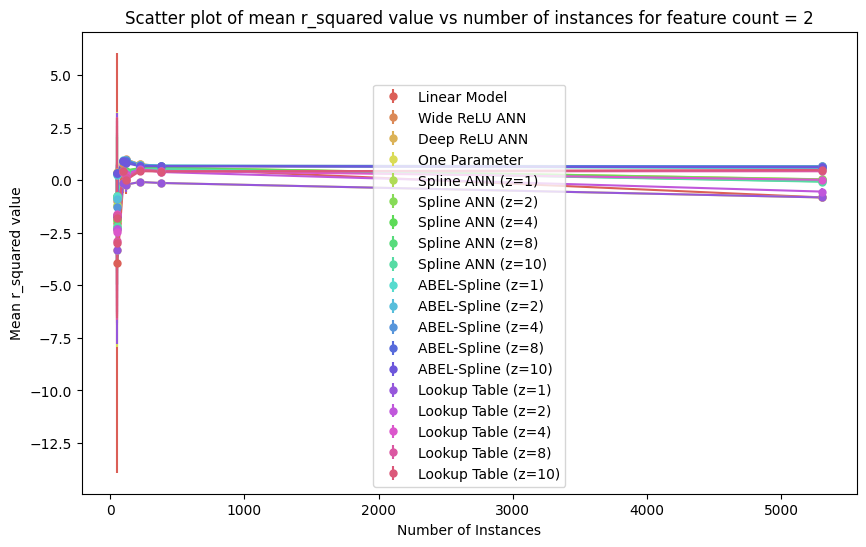

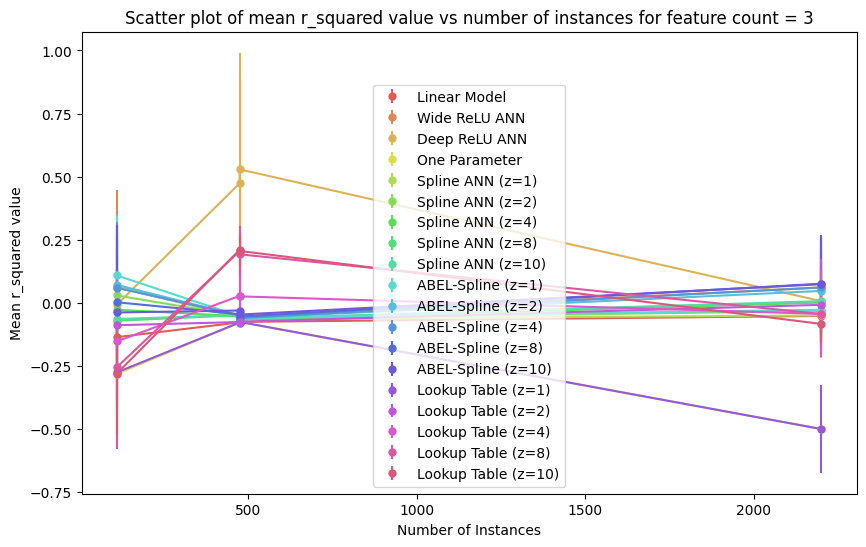

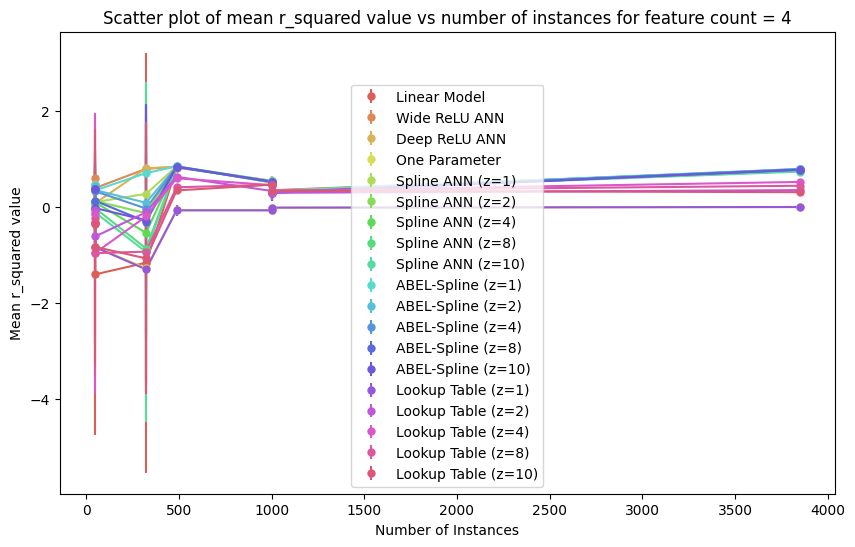

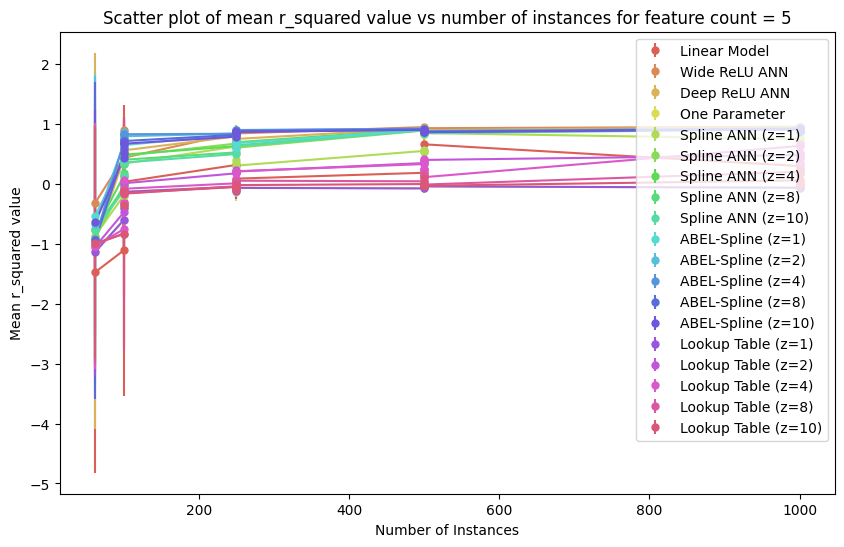

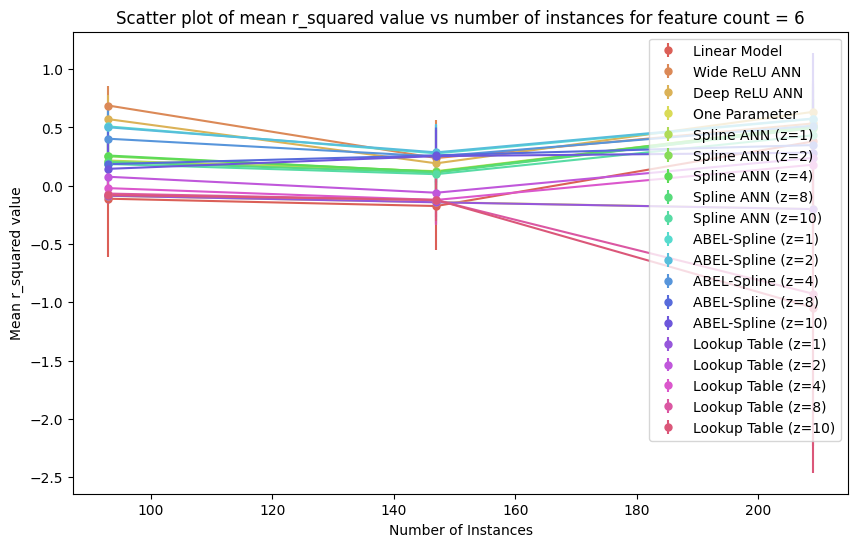

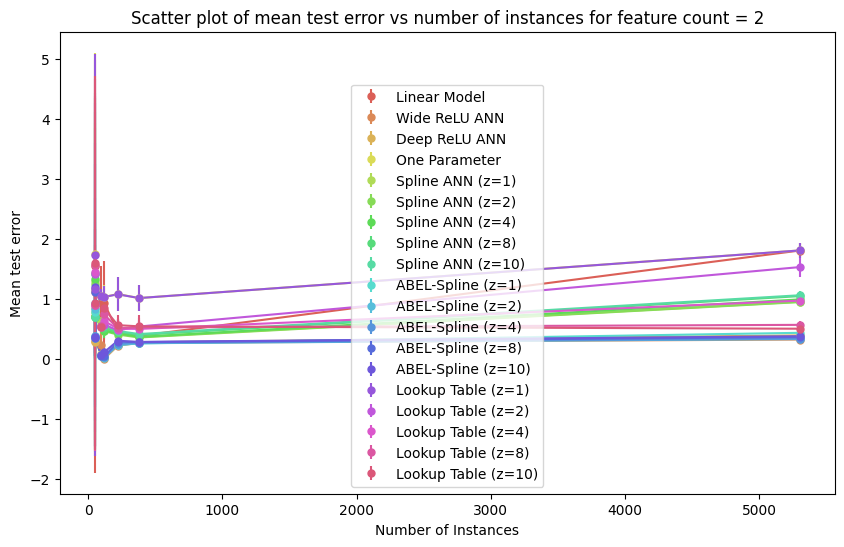

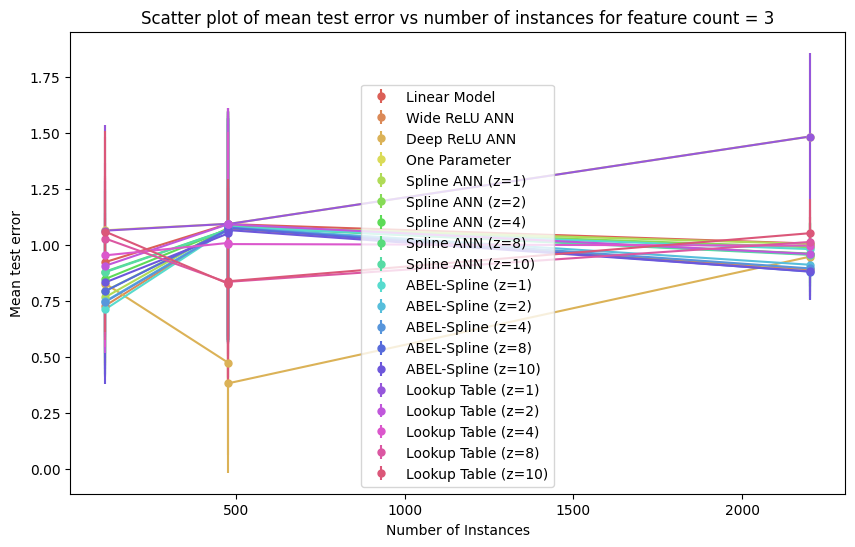

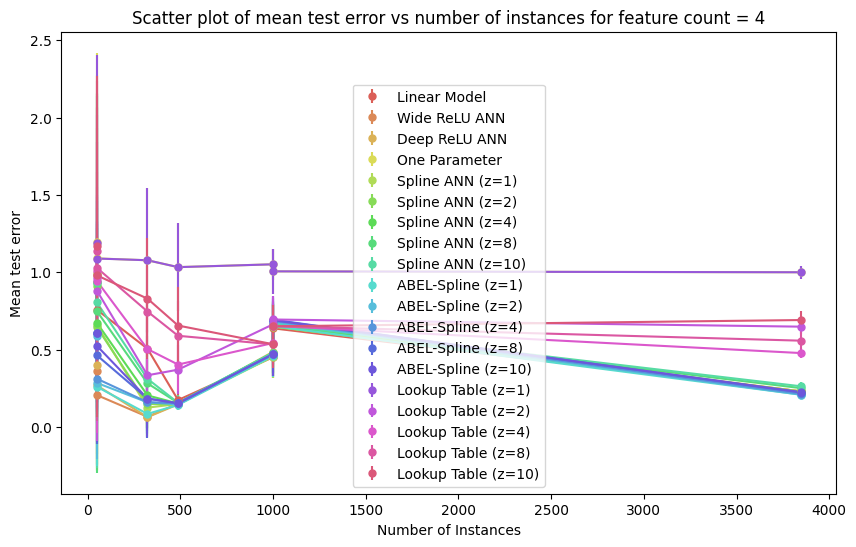

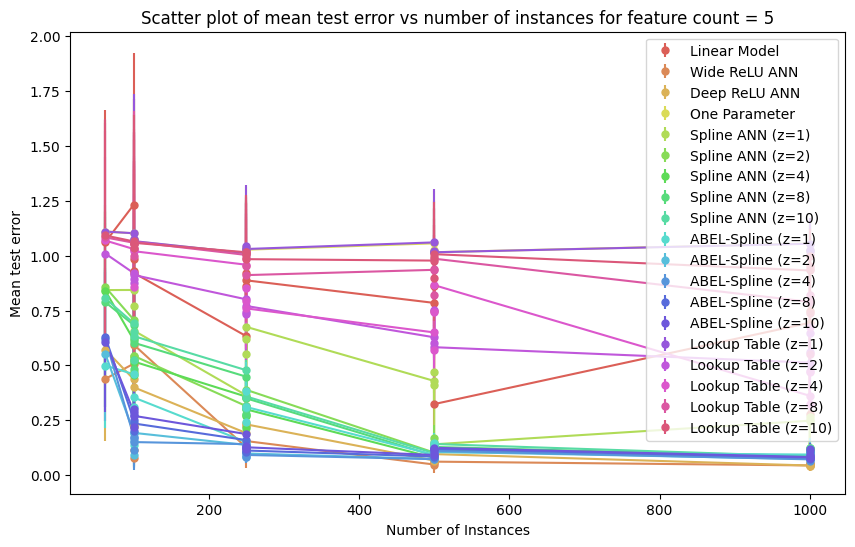

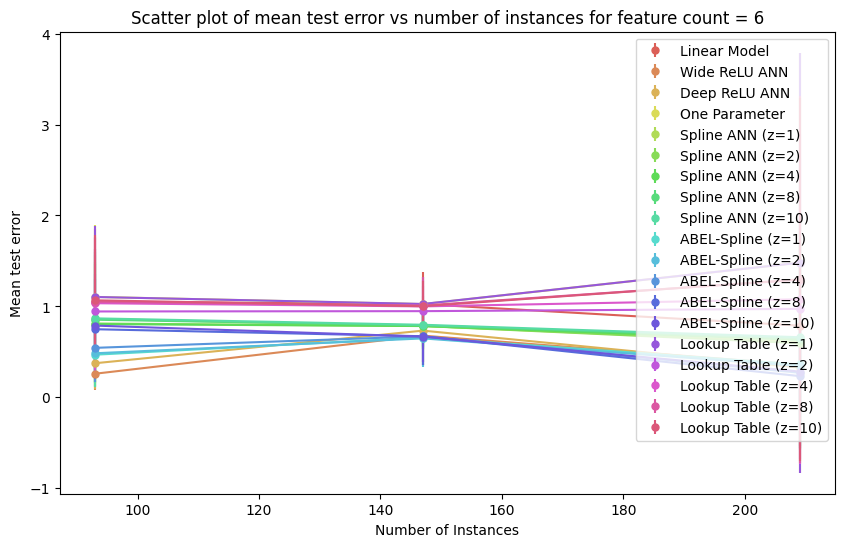

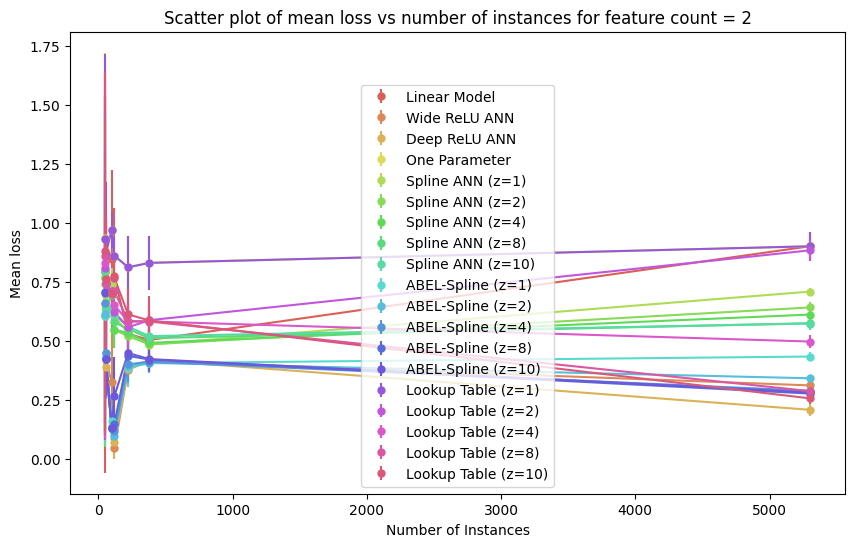

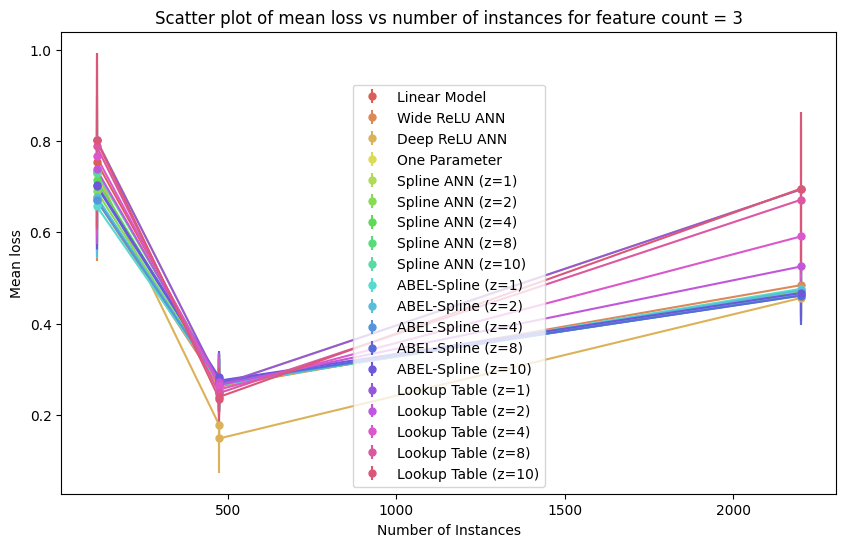

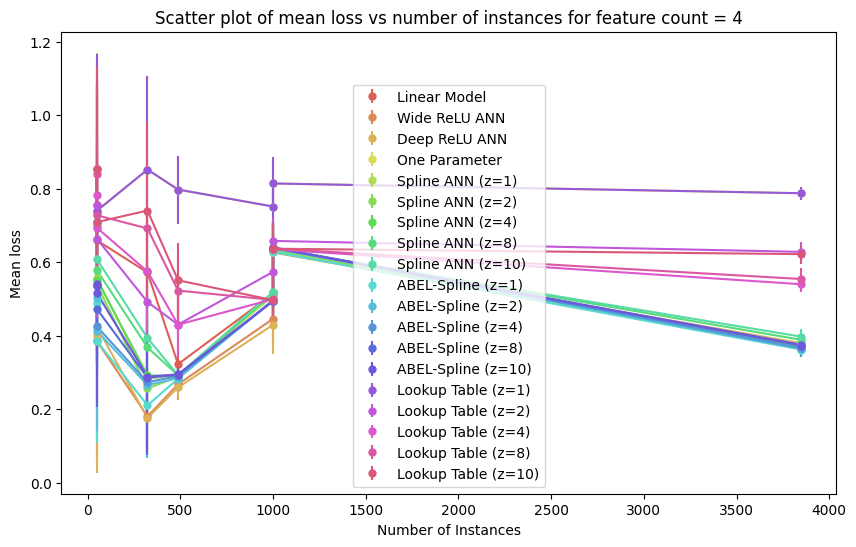

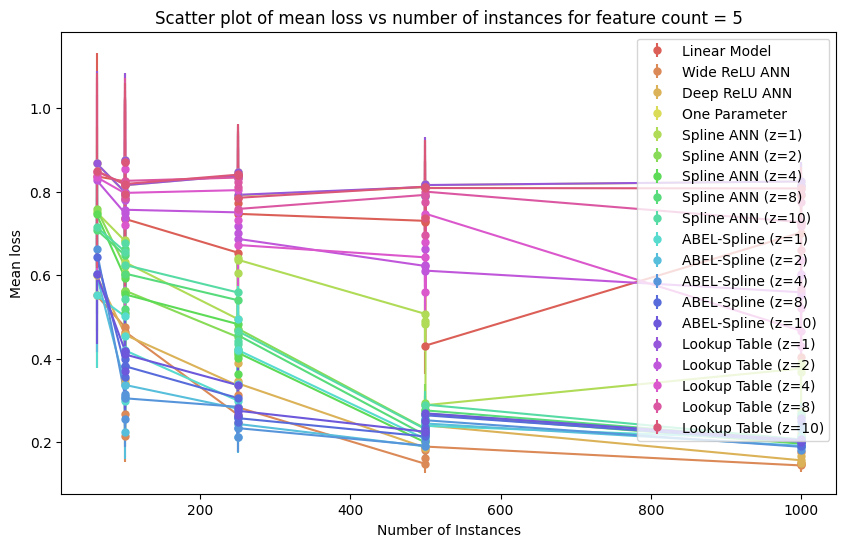

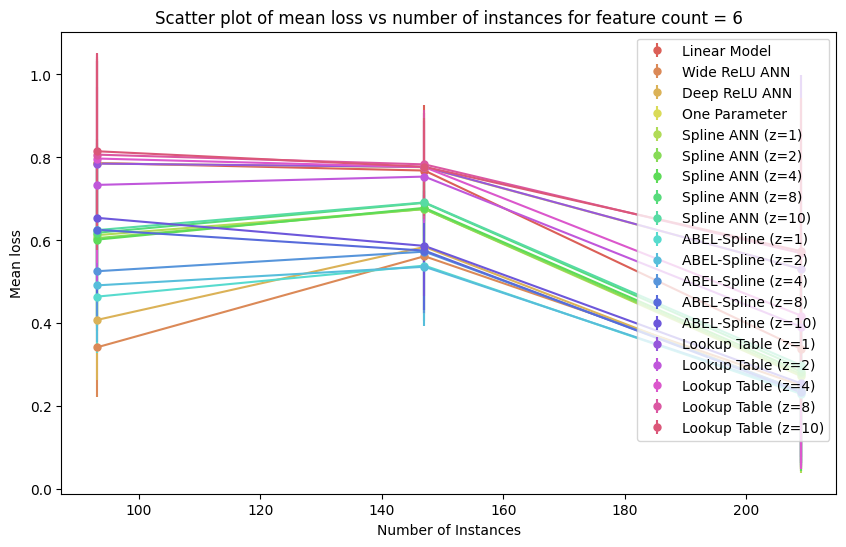

In [20]:
import matplotlib.pyplot as plt 
import seaborn as sns

# Function to create scatter plots of mean metric vs number of instances, with standard deviation error bars
def scatter_plot_metric_vs_instances(means_stds, metric):
    # Create dictionaries mapping dataset names to number of instances and number of features
    instances_dict = filtered_datasets_metadata.set_index('dataset')['n_instances'].to_dict()
    features_dict = filtered_datasets_metadata.set_index('dataset')['n_features'].to_dict()

    # Get all unique feature counts
    unique_features_counts = sorted(list(set(features_dict.values())))

    # Create color palette 
    colors = sns.color_palette("hls", len(model_names))

    # Iterate over feature counts
    for feature_count in unique_features_counts:
        # Get datasets with current feature count and sort them based on number of instances
        datasets_with_feature_count = [dataset for dataset, features in features_dict.items() if features == feature_count]
        sorted_datasets = sorted(datasets_with_feature_count, key=lambda x: instances_dict[x])

        if not sorted_datasets:
            continue

        plt.figure(figsize=(10, 6))
        
        # Iterate over models
        for i, model_name in enumerate(model_names):
            x_values = []
            y_values = []
            y_errors = []
            
            for dataset_name in sorted_datasets:
                if model_name in means_stds[dataset_name]:
                    x_values.append(instances_dict[dataset_name])
                    y_values.append(means_stds[dataset_name][model_name]['mean'])
                    y_errors.append(means_stds[dataset_name][model_name]['std'])

            plt.errorbar(x_values, y_values, yerr=y_errors,
                         marker='o', markersize=5, linestyle='', color=colors[i], label=model_name)
            plt.plot(x_values, y_values, linestyle='-', color=colors[i])

        plt.title(f'Scatter plot of mean {metric} vs number of instances for feature count = {feature_count}')
        plt.xlabel('Number of Instances')
        plt.ylabel(f'Mean {metric}')
        plt.legend()
        plt.show()

# Create scatter plots of mean r_squared value vs number of instances
scatter_plot_metric_vs_instances(mean_std_r_squared_values, 'r_squared value')

# Create scatter plots of mean test_error value vs number of instances
scatter_plot_metric_vs_instances(mean_std_test_error_values, 'test error')

# Create scatter plots of mean loss value vs number of instances
scatter_plot_metric_vs_instances(mean_std_loss_values, 'loss')

In [22]:
import matplotlib.pyplot as plt

# Retrieve dataset and model names
dataset_names = sorted(list(data.keys()), key=lambda x: instances_dict[x])
model_names = [name for _, name in models]

# Initialize 2D array with zeros
image = [[0 for _ in range(len(model_names))] for _ in range(len(dataset_names))]

# Populate 2D list with mean metric values
for i, dataset_name in enumerate(dataset_names):
    for j, model_name in enumerate(model_names):
        if model_name in data[dataset_name]:
            image[i][j] = mean_std_r_squared_values[dataset_name][model_name]['mean']

# Create image plot
plt.imshow(image, cmap='hot', interpolation='nearest')
plt.colorbar(label='Mean Metric Value')

# Set tick labels
plt.xticks(range(len(model_names)), model_names, rotation=90)
plt.yticks(range(len(dataset_names)), dataset_names)

# Show plot
plt.show()

NameError: name 'instances_dict' is not defined

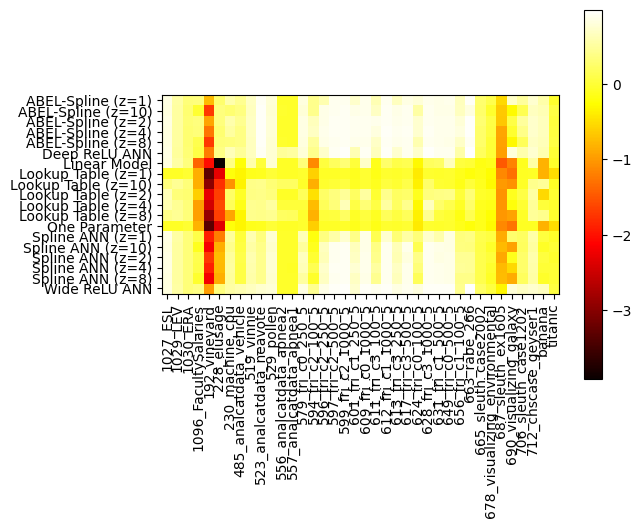

In [23]:
import matplotlib.pyplot as plt

# Prepare data for plot
# Get sorted list of all dataset names
dataset_names = sorted(list(data.keys()))

# Get sorted list of all model names
model_names = sorted(list(next(iter(data.values())).keys()))

# Create 2D numpy array with rows corresponding to models and columns corresponding to datasets
mean_r_squared_values = np.zeros((len(model_names), len(dataset_names)))
for i, model_name in enumerate(model_names):
    for j, dataset_name in enumerate(dataset_names):
        mean_r_squared_values[i, j] = mean_std_r_squared_values[dataset_name][model_name]['mean']

# Create 2D plot
fig, ax = plt.subplots()

# Use imshow to display the 2D array as an image
cax = ax.imshow(mean_r_squared_values, cmap='hot', interpolation='nearest')

# Add colorbar to show how colors map to values
fig.colorbar(cax)

# Set tick labels
ax.set_xticks(np.arange(len(dataset_names)))
ax.set_yticks(np.arange(len(model_names)))
ax.set_xticklabels(dataset_names)
ax.set_yticklabels(model_names)

# Rotate x tick labels so they don't overlap
plt.xticks(rotation=90)

plt.show()

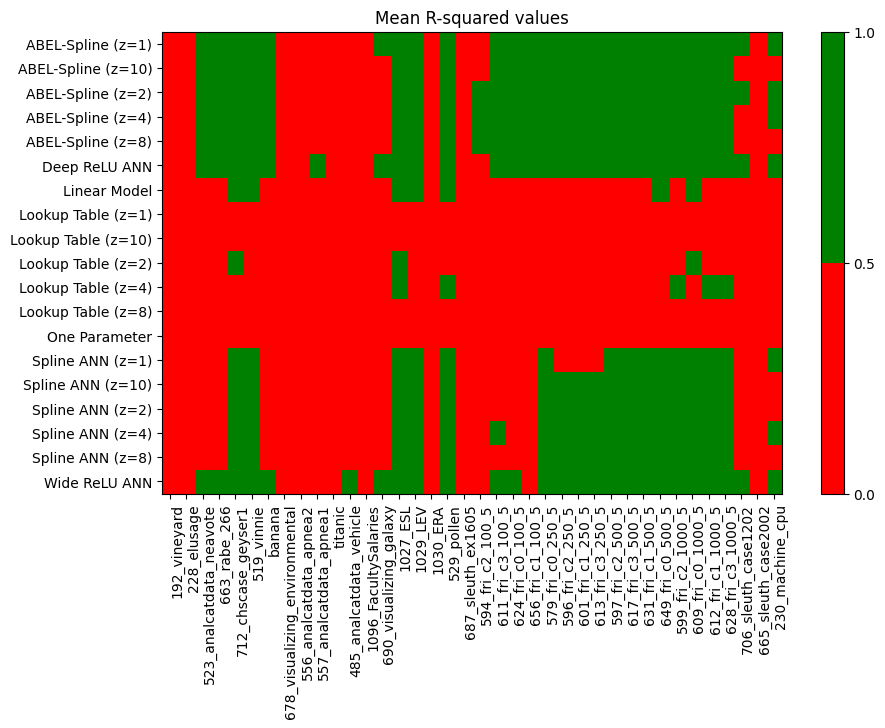

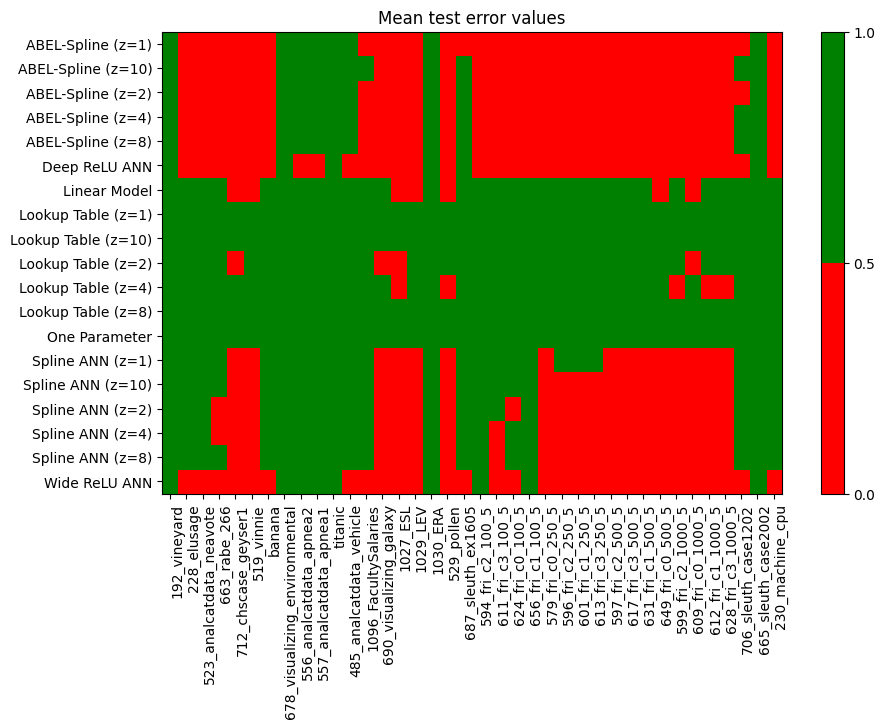

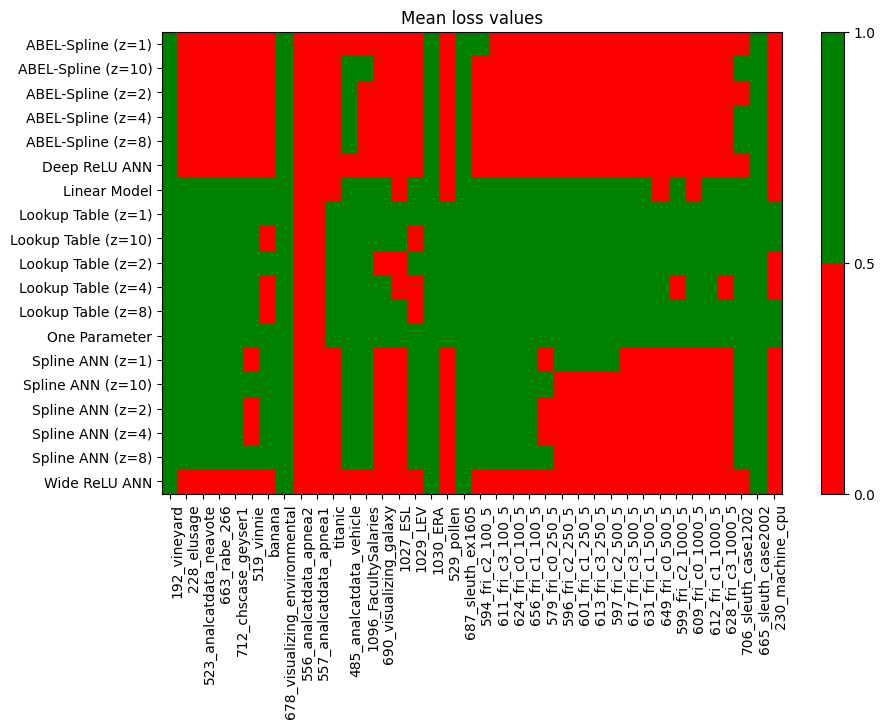

In [27]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

# Function to plot a 2D image of the means of a metric over all models and datasets
def plot_means(metric_means_stds, title):
    # Create dictionaries mapping dataset names to number of instances and number of features
    instances_dict = filtered_datasets_metadata.set_index('dataset')['n_instances'].to_dict()
    features_dict = filtered_datasets_metadata.set_index('dataset')['n_features'].to_dict()

    # Get all unique feature counts
    unique_features_counts = sorted(list(set(features_dict.values())))

    # Initialize lists to hold sorted dataset names and model names
    sorted_dataset_names = []
    
    # Iterate over feature counts
    for feature_count in unique_features_counts:
        # Get datasets with current feature count and sort them based on number of instances
        datasets_with_feature_count = [dataset for dataset, features in features_dict.items() if features == feature_count]
        sorted_datasets = sorted(datasets_with_feature_count, key=lambda x: instances_dict[x])
        
        # Add sorted datasets to list
        sorted_dataset_names.extend(sorted_datasets)
    
    n_datasets = len(sorted_dataset_names)
    n_models = len(model_names)
    
    # Create array with means for each model on each dataset
    means_array = np.empty((n_models, n_datasets))
    
    for i, model_name in enumerate(model_names):
        for j, dataset_name in enumerate(sorted_dataset_names):
            if model_name in metric_means_stds[dataset_name]:
                mean = metric_means_stds[dataset_name][model_name]['mean']
            else:
                mean = np.nan  # Use NaN for missing values
            means_array[i, j] = mean

    # Create figure and axes
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create color map
    cmap = colors.ListedColormap(['red', 'green'])
    bounds = [0,0.5,1]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    # Plot data
    cax = ax.imshow(means_array, aspect='auto', cmap=cmap, norm=norm)

    # Set tick labels
    ax.set_xticks(np.arange(n_datasets))
    ax.set_yticks(np.arange(n_models))
    ax.set_xticklabels(sorted_dataset_names)
    ax.set_yticklabels(model_names)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

     # Create colorbar
    cbar = fig.colorbar(cax)
    
     # Set title
    plt.title(title)
    
     # Show plot
    plt.show()

# Example usage:
plot_means(mean_std_r_squared_values, 'Mean R-squared values')
plot_means(mean_std_test_error_values, 'Mean test error values')
plot_means(mean_std_loss_values, 'Mean loss values')

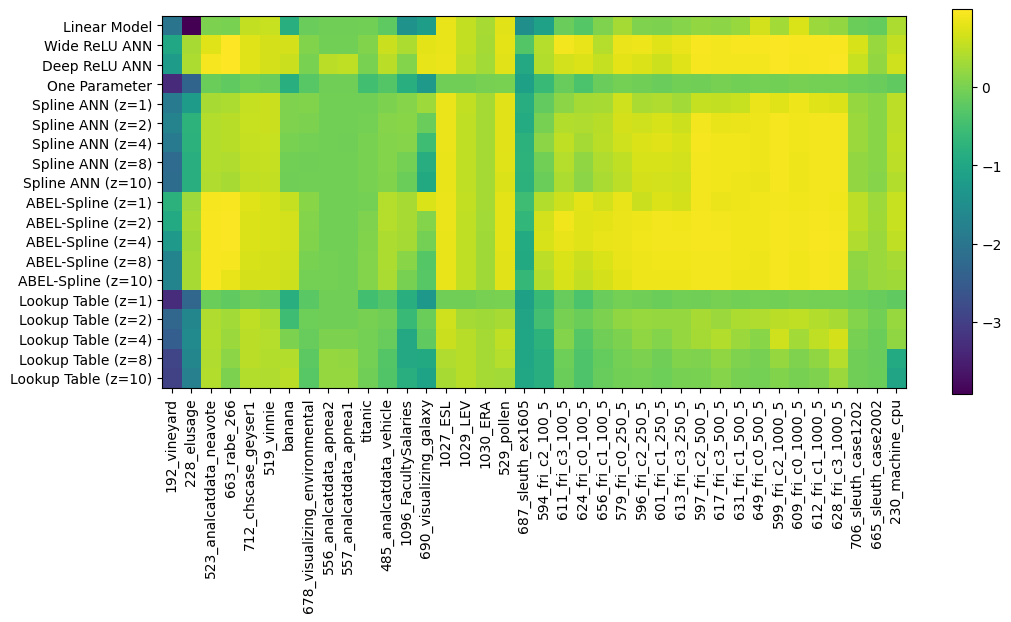

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Create dictionaries mapping dataset names to number of instances and number of features
instances_dict = filtered_datasets_metadata.set_index('dataset')['n_instances'].to_dict()
features_dict = filtered_datasets_metadata.set_index('dataset')['n_features'].to_dict()

# Get all unique feature counts
unique_features_counts = sorted(list(set(features_dict.values())))

# Initialize list to hold sorted dataset names
sorted_dataset_names = []

# Iterate over feature counts
for feature_count in unique_features_counts:
    # Get datasets with current feature count and sort them based on number of instances
    datasets_with_feature_count = [dataset for dataset, features in features_dict.items() if features == feature_count]
    sorted_datasets = sorted(datasets_with_feature_count, key=lambda x: instances_dict[x])
    
    # Add to list of sorted dataset names
    sorted_dataset_names += sorted_datasets

# Initialize 2D numpy array to hold data (r_squared value mean for this example)
data_array = np.zeros((len(model_names), len(sorted_dataset_names)))

# Fill data array with r_squared value means (or other metric)
for i, model_name in enumerate(model_names):
    for j, dataset_name in enumerate(sorted_dataset_names):
        if model_name in mean_std_r_squared_values[dataset_name]:
            data_array[i, j] = mean_std_r_squared_values[dataset_name][model_name]['mean']

# Create 2D imshow plot with colorbar
fig, ax = plt.subplots(figsize=(12, 5))
cax = ax.imshow(data_array, interpolation='nearest', cmap='viridis')
fig.colorbar(cax)

# Set model names as y tick labels
ax.set_yticks(np.arange(len(model_names)))
ax.set_yticklabels(model_names)

# Set sorted dataset names as x tick labels, rotated 90 degrees for better readability
ax.set_xticks(np.arange(len(sorted_dataset_names)))
ax.set_xticklabels(sorted_dataset_names, rotation=90)

# Show plot
plt.show()

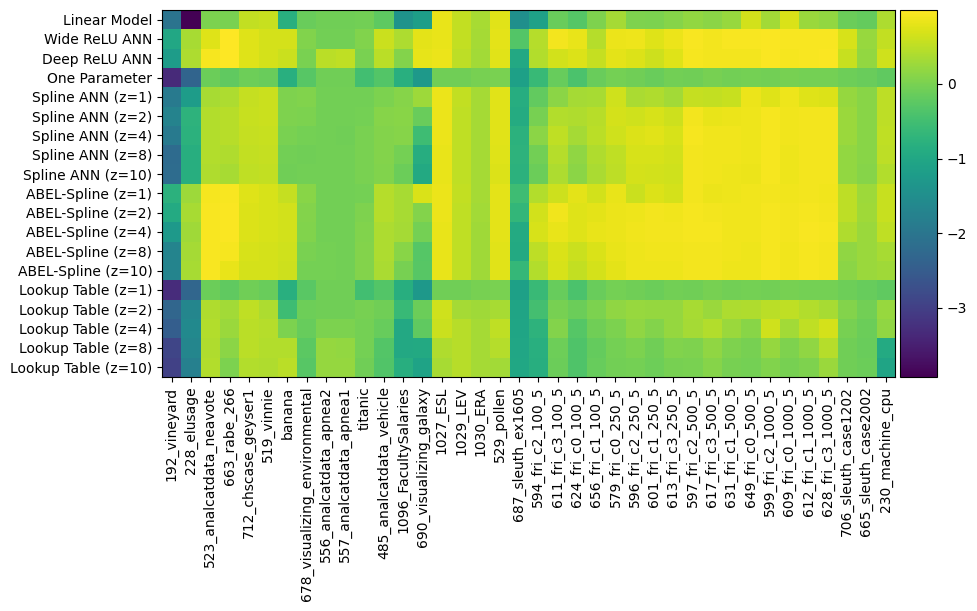

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create dictionaries mapping dataset names to number of instances and number of features
instances_dict = filtered_datasets_metadata.set_index('dataset')['n_instances'].to_dict()
features_dict = filtered_datasets_metadata.set_index('dataset')['n_features'].to_dict()

# Get all unique feature counts
unique_features_counts = sorted(list(set(features_dict.values())))

# Initialize list to hold sorted dataset names
sorted_dataset_names = []

# Iterate over feature counts
for feature_count in unique_features_counts:
    # Get datasets with current feature count and sort them based on number of instances
    datasets_with_feature_count = [dataset for dataset, features in features_dict.items() if features == feature_count]
    sorted_datasets = sorted(datasets_with_feature_count, key=lambda x: instances_dict[x])
    
    # Add to list of sorted dataset names
    sorted_dataset_names += sorted_datasets

# Initialize 2D numpy array to hold data (r_squared value mean for this example)
data_array = np.zeros((len(model_names), len(sorted_dataset_names)))

# Fill data array with r_squared value means (or other metric)
for i, model_name in enumerate(model_names):
    for j, dataset_name in enumerate(sorted_dataset_names):
        if model_name in mean_std_r_squared_values[dataset_name]:
            data_array[i, j] = mean_std_r_squared_values[dataset_name][model_name]['mean']

# Create 2D imshow plot with colorbar
fig, ax = plt.subplots(figsize=(10, len(model_names)/2))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

im = ax.imshow(data_array, interpolation='nearest', cmap='viridis')
fig.colorbar(im, cax=cax, orientation="vertical")

# Set model names as y tick labels
ax.set_yticks(np.arange(len(model_names)))
ax.set_yticklabels(model_names)

# Set sorted dataset names as x tick labels, rotated 90 degrees for better readability
ax.set_xticks(np.arange(len(sorted_dataset_names)))
ax.set_xticklabels(sorted_dataset_names, rotation=90)

# Show plot
plt.show()

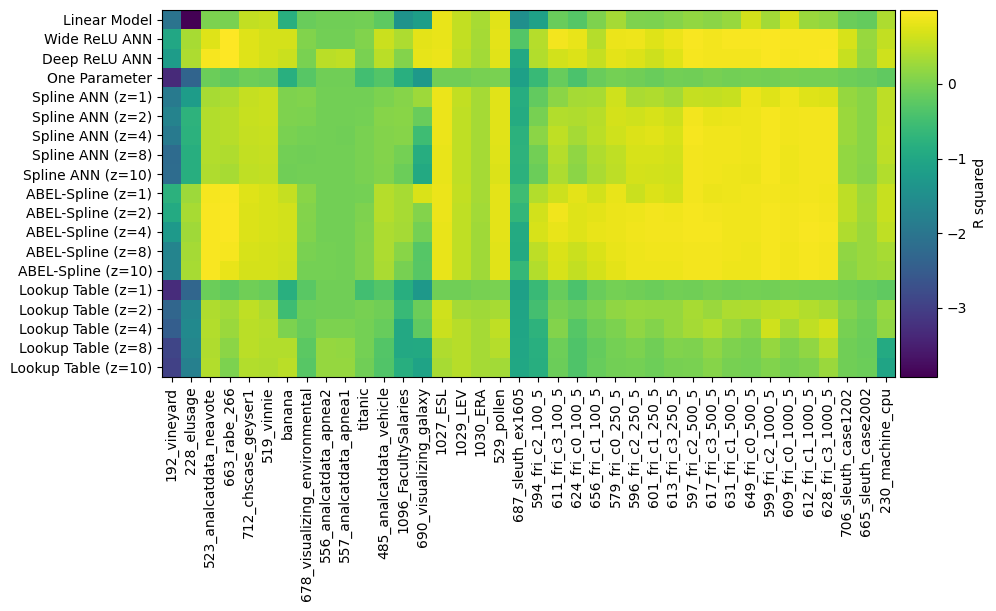

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create dictionaries mapping dataset names to number of instances and number of features
instances_dict = filtered_datasets_metadata.set_index('dataset')['n_instances'].to_dict()
features_dict = filtered_datasets_metadata.set_index('dataset')['n_features'].to_dict()

# Get all unique feature counts
unique_features_counts = sorted(list(set(features_dict.values())))

# Initialize list to hold sorted dataset names
sorted_dataset_names = []

# Iterate over feature counts
for feature_count in unique_features_counts:
    # Get datasets with current feature count and sort them based on number of instances
    datasets_with_feature_count = [dataset for dataset, features in features_dict.items() if features == feature_count]
    sorted_datasets = sorted(datasets_with_feature_count, key=lambda x: instances_dict[x])
    
    # Add to list of sorted dataset names
    sorted_dataset_names += sorted_datasets

# Initialize 2D numpy array to hold data (r_squared value mean for this example)
data_array = np.zeros((len(model_names), len(sorted_dataset_names)))

# Fill data array with r_squared value means (or other metric)
for i, model_name in enumerate(model_names):
    for j, dataset_name in enumerate(sorted_dataset_names):
        if model_name in mean_std_r_squared_values[dataset_name]:
            data_array[i, j] = mean_std_r_squared_values[dataset_name][model_name]['mean']

# Create 2D imshow plot with colorbar
fig, ax = plt.subplots(figsize=(10, len(model_names)/2))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

im = ax.imshow(data_array, interpolation='nearest', cmap='viridis')
cbar = fig.colorbar(im, cax=cax, orientation="vertical")

cbar.set_label('R squared', rotation=90) # label the colorbar

# Set model names as y tick labels
ax.set_yticks(np.arange(len(model_names)))
ax.set_yticklabels(model_names)

# Set sorted dataset names as x tick labels, rotated 90 degrees for better readability
ax.set_xticks(np.arange(len(sorted_dataset_names)))
ax.set_xticklabels(sorted_dataset_names, rotation=90)

# Show plot
plt.show()

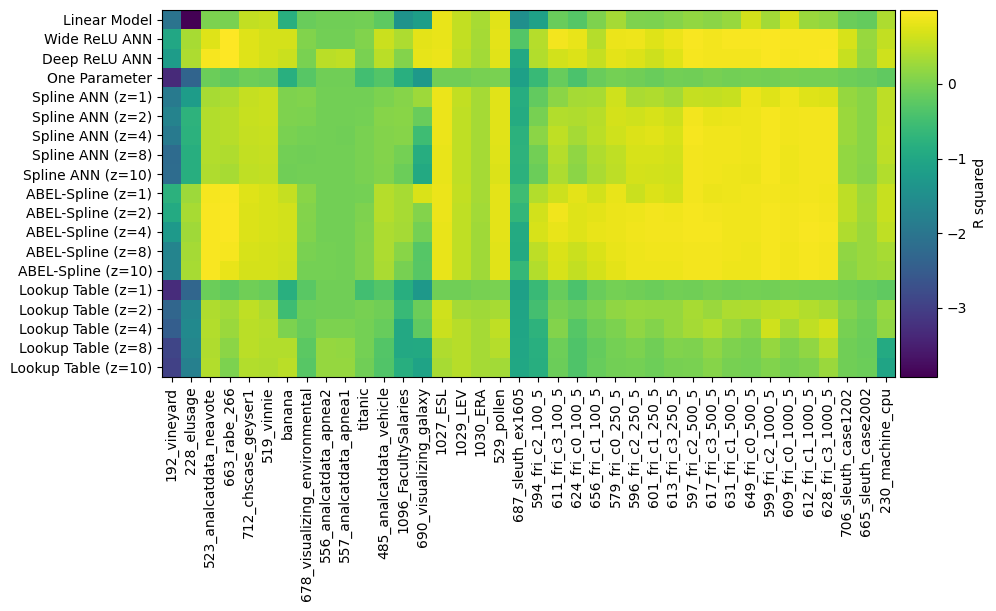

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create dictionaries mapping dataset names to number of instances and number of features
instances_dict = filtered_datasets_metadata.set_index('dataset')['n_instances'].to_dict()
features_dict = filtered_datasets_metadata.set_index('dataset')['n_features'].to_dict()

# Get all unique feature counts
unique_features_counts = sorted(list(set(features_dict.values())))

# Initialize list to hold sorted dataset names
sorted_dataset_names = []

# Iterate over feature counts
for feature_count in unique_features_counts:
    # Get datasets with current feature count and sort them based on number of instances
    datasets_with_feature_count = [dataset for dataset, features in features_dict.items() if features == feature_count]
    sorted_datasets = sorted(datasets_with_feature_count, key=lambda x: instances_dict[x])
    
    # Add to list of sorted dataset names
    sorted_dataset_names += sorted_datasets

# Initialize 2D numpy array to hold data (r_squared value mean for this example)
data_array = np.zeros((len(model_names), len(sorted_dataset_names)))

# Fill data array with r_squared value means (or other metric)
for i, model_name in enumerate(model_names):
    for j, dataset_name in enumerate(sorted_dataset_names):
        if model_name in mean_std_r_squared_values[dataset_name]:
            data_array[i, j] = mean_std_r_squared_values[dataset_name][model_name]['mean']

# Create 2D imshow plot with colorbar
fig, ax = plt.subplots(figsize=(10, len(model_names)/2))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

im = ax.imshow(data_array, interpolation='nearest', cmap='viridis')
cbar = fig.colorbar(im, cax=cax, orientation="vertical")

cbar.set_label('R squared', rotation=90) # label the colorbar

# Set model names as y tick labels
ax.set_yticks(np.arange(len(model_names)))
ax.set_yticklabels(model_names)

# Set sorted dataset names as x tick labels, rotated 90 degrees for better readability
ax.set_xticks(np.arange(len(sorted_dataset_names)))
ax.set_xticklabels(sorted_dataset_names, rotation=90)

# Show plot
plt.show()

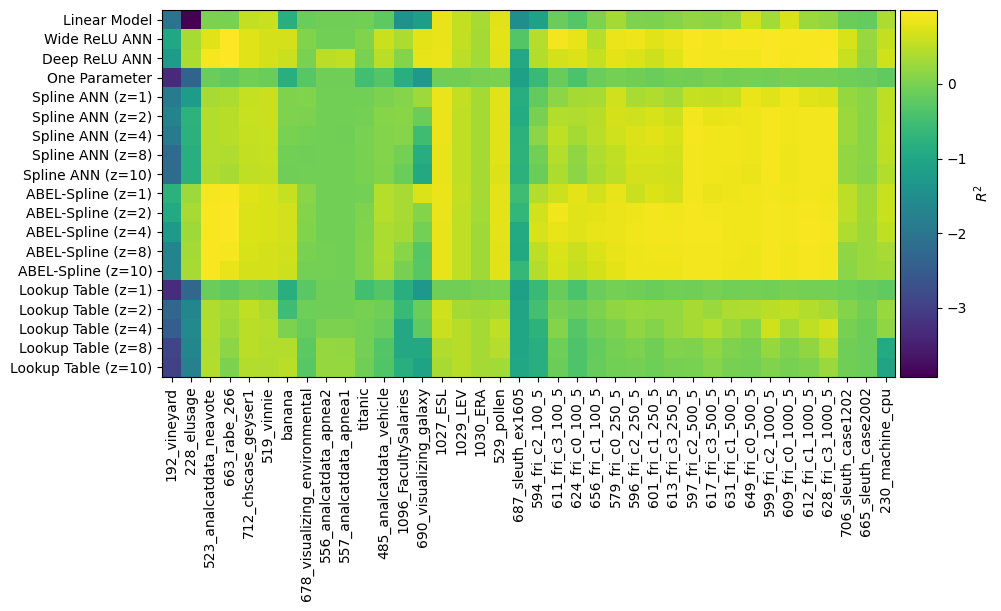

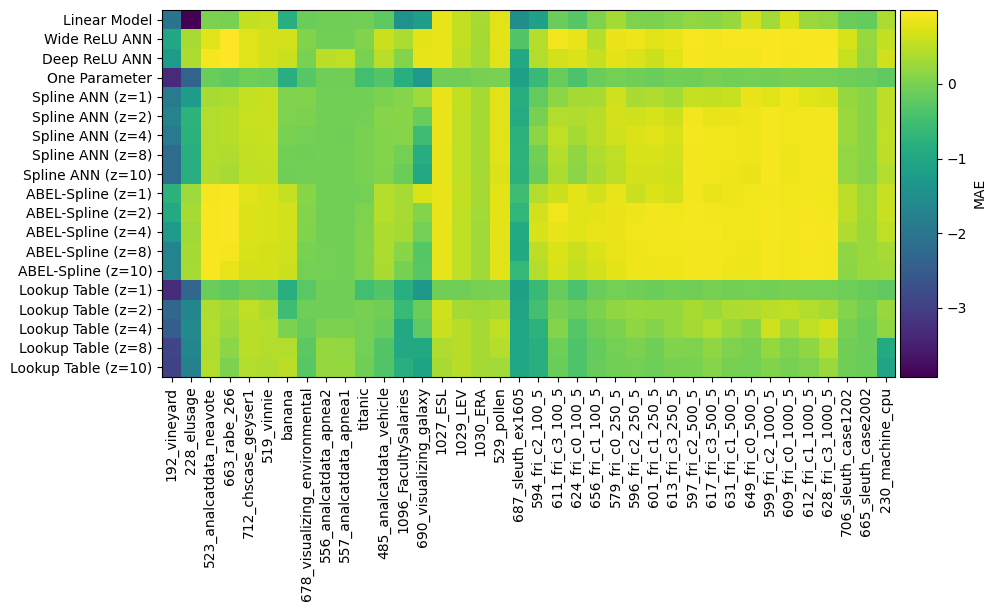

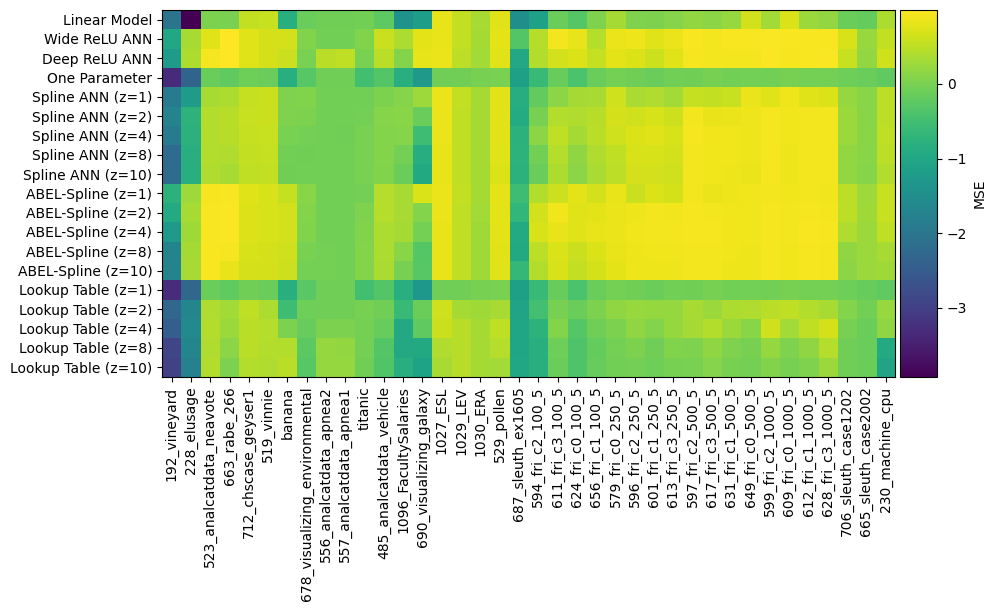

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Metrics labels dictionary
metrics_labels = {
    'loss': 'MAE',
    'r_squared_value': '$R^2$',
    'test_error': 'MSE'
}

def plot_metric(metric):
    # Initialize 2D numpy array to hold data
    data_array = np.zeros((len(model_names), len(sorted_dataset_names)))

    # Fill data array with metric means
    for i, model_name in enumerate(model_names):
        for j, dataset_name in enumerate(sorted_dataset_names):
            if model_name in mean_std_r_squared_values[dataset_name]:
                data_array[i, j] = mean_std_r_squared_values[dataset_name][model_name]['mean']

    # Create 2D imshow plot with colorbar
    fig, ax = plt.subplots(figsize=(10, len(model_names)/2))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    im = ax.imshow(data_array, interpolation='nearest', cmap='viridis')
    cbar = fig.colorbar(im, cax=cax, orientation="vertical")

    # Add label to colorbar using metrics labels dictionary
    cbar.set_label(metrics_labels[metric], rotation=90) 

    # Set model names as y tick labels
    ax.set_yticks(np.arange(len(model_names)))
    ax.set_yticklabels(model_names)

     # Set sorted dataset names as x tick labels, rotated 90 degrees for better readability
    ax.set_xticks(np.arange(len(sorted_dataset_names)))
    ax.set_xticklabels(sorted_dataset_names, rotation=90)

    # Show plot
    plt.show()

# Now you can call this function to plot different metrics
plot_metric('r_squared_value')
plot_metric('loss')
plot_metric('test_error')

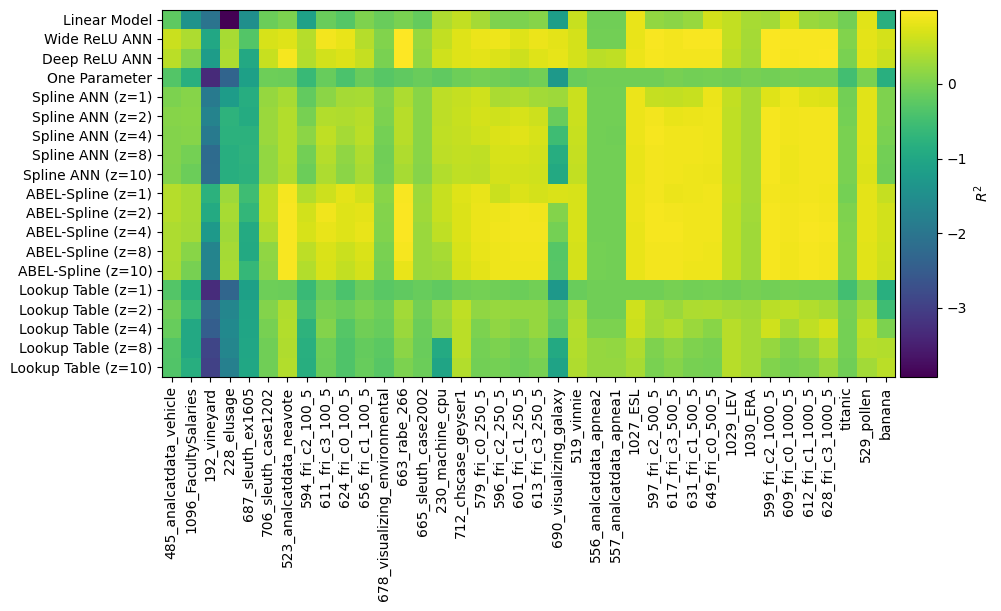